In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.io as sio
from time import time
# from bayes_opt import  BayesianOptimization
import pickle as pkl
import multiprocessing
import sys
sys.path.append(r'/home/datamake94/常用函数')
from Function import *
from datetime import datetime,timedelta

class params:
    oh_data = get_ohdata(oh_factor=['CLOSE_PRICE_2','TURNOVER_VALUE','TURNOVER_VOL','ACCUM_ADJ_FACTOR_2','OPEN_PRICE_2',\
                                   'OPEN_PRICE','CLOSE_PRICE'])
    min_data_path = r'/home/datamake94/data_nb0/min_data'
    score_dict = {
        '1d_min':{
            'tabnet':r'/home/datamake94/database_00/min_score_period30/min_score_lgbm_new_agg_tabnet24',
        },
    }

    index_path = r'/home/datamake94/data_nb0/support_data'
    support_path = r'/home/datamake94/data_nb1/trade_support'
    ohlc_path = r'/home/datamake94/data_nb0/ohlc_fea'
    test_result_path = r'/home/datamake94/data_nb0/min_factor_test_result'

    # 获取交易日列表
    trade_days_df = pd.read_csv(os.path.join(index_path,'交易日编号.csv'),index_col=0,parse_dates=True)-1 # 日期往前挪一天
    trade_days_df.index = [x.to_pydatetime().date() for x in trade_days_df.index]
    date_num = trade_days_df.reset_index().set_index('1')

    zs_w_dict = {'沪深300':0,'中证500':0,'中证1000':1}
    zs_nv_dict = {}
    for zs in ['沪深300','中证500','中证1000']:
        zs_day = pd.read_pickle(os.path.join(index_path,'index_d_close_ts.pkl'))[zs].dropna()
        zs_day.index = pd.to_datetime(zs_day.index).date
        zs_nv = zs_day / zs_day[0]
        zs_nv_dict[zs] = zs_nv.pct_change()
    zs_nv = pd.DataFrame(zs_nv_dict) @ pd.Series(zs_w_dict)
    zs_nv = zs_nv.dropna()
    zs_nv = (zs_nv+1).cumprod()
    zs_nv = zs_nv / zs_nv.iloc[0]

    # 场外信息
    os.chdir(ohlc_path)
    high_limit = pd.read_pickle('LIMIT_UP_PRICE.pkl').replace(0,np.nan).ffill()
    low_limit = pd.read_pickle('LIMIT_DOWN_PRICE.pkl').replace(0,np.nan).ffill()
    pre_close = pd.read_pickle('PRE_CLOSE_PRICE.pkl').replace(0,np.nan).ffill()
    pre_amt = pd.read_pickle('TURNOVER_VALUE.pkl').shift(1).fillna(0)
    adj_factor = pd.read_pickle('ACCUM_ADJ_FACTOR_2.pkl').replace(0,np.nan).ffill()

    upper_price = pre_close + 0.9 * (high_limit - pre_close) # 个股达到涨停价的90%就不再买入
    lower_price = pre_close + 0.9 * (low_limit - pre_close) # 个股达到跌停价的90%就不再卖出
    adj = adj_factor / adj_factor.shift(1)

    # 读取黑名单
    black_df = pd.read_pickle(r'/home/datamake94/data_nb0/black_df_231120.pkl')

#获取所有的秒
min_list = []
for h in [9,10,11,13,14]:
    M = range(30,60) if h==9 else range(0,30) if h==11 else range(0,60)
    for m in M:
        min_list.extend([h*100+m])
# second_list = calc_time_series()
# second_list = sorted([x for x in second_list if int(x) >= 93000 and x <= '144500'])
params.min_list = min_list
params.min_list_valid = [x for x in params.min_list if int(x)>=1000 and int(x) <= 1457]

Duplicate key in file PosixPath('/home/datamake94/.python3.8.0/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 789 ('font.family : sans-serif')
Duplicate key in file PosixPath('/home/datamake94/.python3.8.0/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 790 ('font.sans-serif : SimHei')
Duplicate key in file PosixPath('/home/datamake94/.python3.8.0/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 791 ('axes.unicode_minus : False')


In [22]:
# mad去极值
def mad_winsorize(x:np.array, multiplier:int=5):
    x_M = np.nanmedian(x)
    x_MAD = np.nanmedian(np.abs(x - x_M))
    upper = x_M + multiplier * x_MAD
    lower = x_M - multiplier * x_MAD
    x[x > upper] = upper
    x[x < lower] = lower
    return x

# 因子预处理
def clean_factor(factor_in:pd.DataFrame, fillna:bool=False):
    factor = factor_in.astype('float')
    res = factor.copy()
    res[:] = np.nan
    # 去极值
    for date in factor.index:
        factor_td = factor.loc[date].values
        res.loc[date] = mad_winsorize(factor_td, multiplier=5)
    # 前向填充
    res = res.fillna(method='ffill', limit=10)
    # zs标准化
    res = res.sub(res.mean(1), 0).div(res.std(1), 0)
    if fillna:
        res.fillna(0, inplace=True)
    return res

# 三级因子等权因子合成
def syn_factor_ew(factor_in_list, fillna:bool=False):
    res = clean_factor(factor_in_list[0], fillna=fillna)
    if len(factor_in_list) > 1:
        for factor_in in factor_in_list[1:]:
            factor = clean_factor(factor_in, fillna=fillna)
            res += factor
    res = res.sub(res.mean(1), 0).div(res.std(1), 0)
    return res

def Preprocess_se(idx, code_list, date):
    se = params.style_factor[idx].loc[date]
    se.index = ['%06d'%int(x) for x in se.index]
    se = se.reindex(code_list)
    se = (se - se.mean()) / se.std()
    return se.fillna(0)

def load_style_factor():
    print('正在读取风格因子')
    style_path = r'/home/datamake94/database_00/style_factor'
    style_file_dict = {}
    for style_factor in ['fac_alpha', 'fac_atvr', 'fac_beta', 'fac_cmra', 'fac_daily_std', 'fac_hist_sigma', 'fac_ind_mom', 'fac_lncap', \
        'fac_midcap', 'fac_rs', 'fac_stoa', 'fac_stom', 'fac_stoq', 'fac_strev']:
        style_file = pd.read_feather(os.path.join(style_path, style_factor+'.fea')).set_index('index')
        style_file.columns = style_file.columns.astype(int)
        style_file_dict[style_factor] = style_file.sub(style_file.mean(axis=1), 0).div(style_file.std(axis=1), 0)

    fac_size = syn_factor_ew([style_file_dict['fac_lncap']])
    fac_mid_size = syn_factor_ew([style_file_dict['fac_midcap']])
    fac_volatility = syn_factor_ew([style_file_dict['fac_beta'], style_file_dict['fac_hist_sigma'], style_file_dict['fac_daily_std'], style_file_dict['fac_cmra']])
    fac_liquidity = syn_factor_ew([style_file_dict['fac_stom'], style_file_dict['fac_stoq'], style_file_dict['fac_stoa'], style_file_dict['fac_atvr']])
    fac_momentum = syn_factor_ew([style_file_dict['fac_strev'], style_file_dict['fac_ind_mom'], style_file_dict['fac_rs'], style_file_dict['fac_alpha']])
    return {
        'size': fac_size,
        'mid_size': fac_mid_size,
        'volatility': fac_volatility,
        'liquidity': fac_liquidity,
        'momentum': fac_momentum
    }, style_file_dict
big_dict, small_dict = load_style_factor()
params.style_factor = big_dict
params.style_factor_small = small_dict

In [45]:
import cvxpy as cp
def analyse(nv,plotting=False):
    ret = nv['strategy'].diff().dropna()
    mean_ret = ret.mean() * 250
    mean_std = ret.std() * np.sqrt(250)
    sharp_ratio = mean_ret / mean_std
    dd_s = nv['strategy'].cummax() - nv['strategy']
    mean_dd = dd_s.mean()
    max_dd = dd_s.max()
    dd_date = dd_s.sort_values(ascending=False).index[0]

    new_zs = nv['zs']
    zs_ret = new_zs.diff().dropna()
    excess_ret = ret - zs_ret
    ana_ex_ret = excess_ret.mean() * 250
    ana_ex_std = excess_ret.std() * np.sqrt(250)
    info_ratio = ana_ex_ret / ana_ex_std
    rel_nv = 1 + excess_ret.cumsum()
    rel_dd_s =  rel_nv.cummax() - rel_nv
    rel_mean_dd = rel_dd_s.mean()
    rel_max_dd = rel_dd_s.max()
    rel_dd_date = rel_dd_s.sort_values(ascending=False).index[0]
    info_ratio2 = ana_ex_ret / rel_max_dd

    nv_df = pd.concat([nv['strategy'], new_zs, rel_nv], axis=1,
                      keys=['strategy', 'benchmark', 'relative'],
                      sort=False).fillna(1)
    
    if plotting is True:
        print('------绝对收益------')
        print('年化收益:' + str(mean_ret))
        print('年化波动:' + str(mean_std))
        print('夏普比率:' + str(sharp_ratio))
        print('平均回撤:' + str(mean_dd))
        print('最大回撤:' + str(max_dd))
        print('回撤日期:' + str(dd_date))
        print('------相对收益------')
        print('超额年化收益:' + str(ana_ex_ret))
        print('超额年化波动:' + str(ana_ex_std))
        print('超额夏普比率:' + str(info_ratio))
        print('超额平均回撤:' + str(rel_mean_dd))
        print('超额最大回撤:' + str(rel_max_dd))
        print('超额回撤日期:' + str(rel_dd_date))
        print('收益回撤比:' + str(info_ratio2))
        
        nv_df.plot(figsize=(40, 10))
        plt.show()

    info_s = pd.Series([ana_ex_ret, ana_ex_std, info_ratio, rel_max_dd, rel_mean_dd, rel_dd_date, info_ratio2],
                       index=['超额年化收益', '超额年化波动', '超额夏普比率', '超额最大回撤', '超额平均回撤', '超额回撤日期', '收益回撤比'])
    return info_s, nv_df, rel_nv

class stk:
    def __init__(self, code, up_price, low_price, pre_close, minute_amt=10000, trade_fee=0.0015):
        '''
        对于每只股票，创建一个对象，用于管理个股信息以及执行个股交易
        '''
        self.code = code
        self.up_price = up_price  # 涨停价，涨停不买，跌停不卖
        self.low_price = low_price  # 跌停价
        self.pre_close = pre_close # 个股昨收价
        self.lastday_vol = 0  # 当日剩余可卖量，初始为0，持有一日之后，可卖量为前一日持有量
        self.trade_fee = trade_fee  # 交易费用与冲击成本，卖出时考虑
        self.minute_amt_b = minute_amt # 个股当前时点可买入的最大金额
        self.minute_amt_s = minute_amt # 个股当前时点可卖出的最大金额
        self.volume = 0  #  持仓量
        self.amt = 0  # 持仓市值
        self.pre_amt = 0 # 根据昨收价计算的个股配置市值
        self.minimum_vol = 200 if ('%06d'%int(code))[:2]=='68' else 100 # 68开头的沪市科创板股票最少交易200股
        self.hold_date = 0  # 个股已持仓日期数
    
    def update_info(self, up_price, low_price, pre_close, trade_fee=0.0015): # 每日开盘刷新个股行业、市值分组、涨跌停价等
        self.up_price = up_price  # 涨停价
        self.low_price = low_price  # 跌停价
        self.pre_close = pre_close # 个股昨收价
        self.pre_amt = pre_close * self.volume # 个股昨收市值
        self.trade_fee = trade_fee
        
    def update_price(self, price):  # 更新个股的价格以及持仓市值
        self.price = price
        self.amt = self.volume * price

    def buy(self, volume):  # 买入个股，记录成交信息，刷新持仓市值，返回成交金额；
        amt = volume * self.price # 当前买入金额
        pre_amt = volume * self.pre_close # 买入调整的配置市值
        self.volume += volume  # 更新个股累计持仓量
        self.amt = self.volume * self.price  #更新个股累计持仓市值
        self.pre_amt = self.volume * self.pre_close # 根据昨收价计算的个股配置市值
        self.minute_amt_b -= amt # 当前分钟可买入金额减少
        return (amt, pre_amt, self.volume, self.amt)  # 返回买入金额，配置新增额，持仓量、持仓市值
        
    def sell(self, volume):  # 卖出个股，记录成交信息，刷新持仓市值，返回成交金额；
        amt = volume * self.price * (1-self.trade_fee)  # 卖出时扣除手续费和冲击成本
        pre_amt = volume * self.pre_close # 卖出调整的配置市值
        self.volume -= volume # 更新个股持仓量
        self.lastday_vol -= volume # 更新个股当日可卖量
        self.minute_amt_s -= amt # 当前分钟可卖出金额减少
        self.amt = self.volume * self.price # 更新个股持仓市值
        self.pre_amt = self.volume * self.pre_close # 根据昨收价计算的个股配置市值
        return (amt, pre_amt, self.volume, self.amt)  # 返回卖出金额，配置减少额，持仓量、持仓市值

class account:
    '''
    创建一个账户类，用于刷新账户信息，管理股票信息，规划交易任务以及执行
    '''
    def __init__(self,money):
        self.code_list = []  # 可考虑的股票列表
        self.tot_account = money  # 总资产，初始化为总现金
        self.stk_dict = {}  # 全市场股票信息
        self.hold_dict = {}  # 持仓股票信息
        self.trade_dict = {}  # 个股交易记录，分股票
        
        self.decision_list = []  # 记录决策列表
        self.time = ' '  # 当前时间戳
        self.cash = money
    
    def cal_tot(self): # 刷新持仓信息，统计账户总市值
        tot = 0
        # for code in self.hold_dict.keys():
        #     self.hold_dict[code] = [self.stk_dict[code].volume, self.stk_dict[code].amt]
        #     tot += self.stk_dict[code].amt
        for code in self.stk_dict.keys():
            if self.stk_dict[code].price != 0 and ~np.isnan(self.stk_dict[code].price):
                self.stk_dict[code].amt = self.stk_dict[code].volume * self.stk_dict[code].price
                tot += self.stk_dict[code].amt
        self.tot_account = tot+self.cash
        return self.tot_account
    
    def refresh_open(self, code_list, td_adj, td_support, td_upper,td_lower,td_pre_close,perm_ratio,stk_citic,zs_citic,zs_member,zs_member_dict,date_str,pre_date_str):  # 每天开盘刷新策略持仓相关信息
        '''
        code_list 为当日可考虑的股票池
        td_citic 全市场个股行业信息
        td_cmvg 全市场市值分组信息
        td_upper 全市场个股当日涨停价
        td_lower 全市场个股当日跌停价
        '''
        
        if date_str < '20230828': trade_fee = 0.0015
        else: trade_fee = 0.001
        for code in code_list: # 开盘刷新所有个股信息，可能有新上市的，可能有市值分组变动的，涨跌停价格也会发生变化
            if code not in self.stk_dict.keys():  # 新上市股票信息新增
                self.stk_dict[code] = stk(code,td_upper[code], td_lower[code],td_pre_close[code],trade_fee=trade_fee)
            else:   # 已上市股票信息刷新
                self.stk_dict[code].update_info(td_upper[code], td_lower[code],td_pre_close[code],trade_fee=trade_fee) # 更新个股行业、市值、涨跌停价等
        for code in self.stk_dict.keys():
            self.stk_dict[code].lastday_vol = self.stk_dict[code].volume
        self.fresh_adj(td_adj)
        self.fresh_price(pd.Series(td_pre_close).reindex(code_list).to_dict())

        self.zs_citic = zs_citic
        self.citic_mtx = pd.get_dummies(stk_citic).T.sort_index(axis=0).astype(int).reindex(index=zs_citic.index,columns=code_list).fillna(0)
        
        self.style_cons_se = {}
        self.zs_style_se = {}
        for style in ['size','mid_size','volatility','liquidity','momentum']:
            self.style_cons_se[style] = Preprocess_se(style, code_list, pre_date_str)
            self.zs_style_se[style] = zs_member @ self.style_cons_se[style]
        # for style in ['fac_alpha', 'fac_atvr', 'fac_beta', 'fac_cmra', 'fac_daily_std', 'fac_hist_sigma', 'fac_ind_mom', 'fac_lncap', \
        #     'fac_midcap', 'fac_rs', 'fac_stoa', 'fac_stom', 'fac_stoq', 'fac_strev']:
        #     self.style_cons_se[style] = Preprocess_se(style, code_list, pre_date_str)
        #     self.zs_style_se[style] = zs_member @ self.style_cons_se[style]
        
        self.zs_member_se = {}
        for idx in zs_member_dict.keys():
            self.zs_member_se[idx] = np.sign(zs_member_dict[idx].reindex(code_list).fillna(0).values)

        # 微盘股限制
        self.tiny_stock_se = (td_support['cmv_group'] == 6).reindex(code_list).fillna(0).values
        
        # self.cmvg_se = Preprocess_se('size', code_list, pre_date_str)
        # self.midsize_se = Preprocess_se('mid_size', code_list, pre_date_str)
        # self.volatility_se = Preprocess_se('volatility', code_list, pre_date_str)
        # self.liquidity_se = Preprocess_se('liquidity', code_list, pre_date_str)
        # self.momentum_se = Preprocess_se('momentum', code_list, pre_date_str)
        self.code_list = code_list
        self.perm_up = (zs_member.reindex(code_list)+perm_ratio).fillna(perm_ratio)
        self.perm_low = (zs_member.reindex(code_list)-perm_ratio).fillna(0)
        self.perm_low[self.perm_low<0] = 0
        return self.cal_tot()
    
    def log_trade(self, code, price, bsvolume): # 交易记录
        if code not in self.trade_dict.keys():
            self.trade_dict[code] = []
        self.trade_dict[code].append([bsvolume, price, self.time])
    
    # def update_perm(self, code, pre_amt): # 刷新策略的行业、市值暴露额度
    #     '''
    #     每当有买入或者卖出成交时，对应的行业及市值组持仓市值会变化，所以相应改变剩余可买额度，和可卖额度
    #     当买入个股时，amt>0，需要减少对应的可买额度，增加可卖额度
    #     当卖出个股时，amt<0，需要增加对应的可买额度，减少可卖额度
    #     '''
    #     citic0 = self.stk_dict[code].citic
    #     cmvg0 = self.stk_dict[code].cmvg
    #     self.citic_perm_b[citic0] -= pre_amt
    #     self.cmvg_perm_b[cmvg0] -= pre_amt
    #     self.citic_perm_s[citic0] += pre_amt
    #     self.cmvg_perm_s[cmvg0] += pre_amt

    def buy_stk(self, code, volume): # 买入股票
        amt, pre_amt, hold_vol, hold_amt = self.stk_dict[code].buy(volume)
        self.log_trade(code,self.stk_dict[code].price, volume)
        self.hold_dict[code] = (hold_vol, hold_amt)
        self.stk_dict[code].hold_date = 0  # 买入后持仓日期数归零
        self.cash -= amt
        if self.cash<0:
            raise ValueError(code+':'+str(volume)+'现金不足买入')
        return amt
    
    def sell_stk(self, code, volume): # 卖出股票
        amt, pre_amt, hold_vol, hold_amt = self.stk_dict[code].sell(volume)
        self.log_trade(code,self.stk_dict[code].price, -volume)
        if hold_vol>0:
            self.hold_dict[code] = (hold_vol, hold_amt)
        else:
            del self.hold_dict[code] # 清仓后不再持有该只个股
        self.cash += amt
        return amt

    def fresh_minute(self, minute_amt_dict,price_s): # 每分钟刷新个股的分钟可参与金额和成交价
        for code in minute_amt_dict.keys():
            # try:
            self.stk_dict[code].minute_amt_b = minute_amt_dict[code]
            self.stk_dict[code].minute_amt_s = minute_amt_dict[code]
            self.stk_dict[code].update_price(price_s[code])  # 刷新个股价格
            # except:
            #     pass
        
    def fresh_price(self, price_s,td_adj=None): # 每分钟刷新个股的分钟收盘价
        # if td_adj is None:
        #     return
        # else:
        #     for code in td_adj:
        #         if code in self.hold_dict.keys():
        #             self.stk_dict[code].volume = self.stk_dict[code].volume * td_adj[code] # 调整个股持仓量
        #             self.hold_dict[code][0] = self.stk_dict[code].volume
        
        for code in price_s.keys():
        #     try:
            self.stk_dict[code].update_price(price_s[code])  # 刷新个股价格
            # except:
            #     pass

    def fresh_adj(self, td_adj):
        for code in td_adj:
            if code in self.hold_dict.keys():
                self.stk_dict[code].volume = self.stk_dict[code].volume * td_adj[code]
                # self.hold_dict[code][0] = self.stk_dict[code].volume
                self.hold_dict[code] = (self.stk_dict[code].volume, self.stk_dict[code].volume * self.stk_dict[code].price)

    # def decide_clean_1(self, max_buy, max_sell, price_s, score_se, min_amt, style_cons, turnover_cons, zs_score=None, min_turnlimit = 1): # 每分钟根据最新的打分排序，以及可以买卖的金额，做出任务计划
    #     '''
    #     max_buy 当前分钟可买入金额
    #     max_sell 当前分钟可卖出金额
    #     buy_codes 考虑买入的股票池，根据打分从大到小排序
    #     sell_codes 考虑卖出的股票池，根据打分从小到大排序
    #     '''
    #     tot_buy_amt = 0
    #     tot_sell_amt = 0
    #     ans_str = self.time

    #     # 开始组合优化
    #     cons = []
    #     n = len(self.code_list)
    #     zeros = np.repeat(0, n).T
    #     ones = np.repeat(1, n).T
    #     allhold_amt = cp.Variable(n)
    #     prehold_amt = np.array([self.stk_dict[code].amt for code in self.code_list]) / self.tot_account

    #     for up_thres in range(0,1):
    #         # 风格中性化
    #         # for style in ['size','mid_size','volatility','liquidity']:
    #         for style in ['fac_alpha', 'fac_atvr', 'fac_beta', 'fac_cmra', 'fac_daily_std', 'fac_hist_sigma', 'fac_ind_mom', 'fac_lncap', \
    #             'fac_midcap', 'fac_rs', 'fac_stoa', 'fac_stom', 'fac_stoq', 'fac_strev']:
    #             cons.extend([
    #                 allhold_amt @ self.style_cons_se[style] <= self.zs_style_se[style] + style_cons*2 + up_thres * 0.001,
    #                 allhold_amt @ self.style_cons_se[style] >= self.zs_style_se[style] - style_cons*2 - up_thres * 0.001,
    #             ])
    #         # 行业中性化
    #         cons.extend([
    #             self.citic_mtx.values @ allhold_amt <= self.zs_citic + 0.02*2 + up_thres * 0.001,
    #             self.citic_mtx.values @ allhold_amt >= self.zs_citic - 0.02*2 - up_thres * 0.001,
    #         ])
    #         # # 指数成分股占比
    #         # for idx in ['hs300','zz500','zz1000']:
    #         #     cons.extend([
    #         #         self.zs_member_se[idx] @ allhold_amt >= 0.65*params.zs_w_dict[{'hs300':'沪深300','zz500':'中证500','zz1000':'中证1000'}[idx]]
    #         #     ])
    #         # # 微盘股占比
    #         # cons.extend([
    #         #     self.tiny_stock_se @ allhold_amt <= 0.05
    #         # ])
    #         # print('citic',self.citic_mtx.values @ prehold_amt - self.zs_citic)
    #         # 持仓限制
    #         max_sell_se = pd.Series([self.stk_dict[code].lastday_vol * price_s[code] for code in self.code_list],index=self.code_list) / self.tot_account
    #         cons.extend([
    #             allhold_amt <= np.maximum(self.perm_up*2,prehold_amt),
    #             allhold_amt >= np.minimum(self.perm_low,prehold_amt),
    #             ###
    #             cp.sum(allhold_amt) <= 1,
    #             cp.abs(allhold_amt - prehold_amt) <= min_amt.values / self.tot_account,
    #             prehold_amt - allhold_amt <= max_sell_se.values,
    #         ])
    #         # alpha_r = pd.Series(score_se).rank(pct=True).values
    #         cons.extend([
    #             cp.pos(allhold_amt - prehold_amt) <= (max_sell_se.values > 0).astype(int),
    #             # cp.neg(allhold_amt - prehold_amt) <= (alpha_r <= 0.3).astype(int),
    #         ])
    #         # # 添加择时
    #         # if not only_buy:
    #         #     # cons.extend([
    #         #     #     cp.pos(allhold_amt - prehold_amt) <= np.sign(zs_score)
    #         #     # ])
    #         #     cons.extend([
    #         #         # allhold_amt <= np.maximum(0,(prehold_amt - (zs_score<=-3).astype(int) * max_sell_se.values)) * (zs_score<=-3).astype(int) + 1 * (zs_score>-3).astype(int),
    #         #         # cp.neg(allhold_amt - prehold_amt) <= (zs_score <= 3).astype(int)
    #         #         # allhold_amt >= (zs_score >= 3).astype(int) * max_sell_se.values * 2,
    #         #         cp.pos(allhold_amt - prehold_amt) <= (zs_score >= 0.5).astype(int),
    #         #         cp.neg(allhold_amt - prehold_amt) <= (zs_score <= -0.5).astype(int),
    #         #     ])
    #         # if only_buy:
    #         #     cons.extend([
    #         #         cp.neg(allhold_amt - prehold_amt) <= 0
    #         #     ])

    #         # 打分最大化，添加换手率惩罚项
    #         score_se = score_se - score_se.mean()
    #         #0.5
    #         obj = cp.Maximize(score_se @ allhold_amt - turnover_cons * cp.norm(allhold_amt - prehold_amt, 1))
    #         prob = cp.Problem(obj, cons)
    #         ans = prob.solve(solver='SCIPY',verbose=False)
    #         if allhold_amt.value is not None:
    #             break
    #     if allhold_amt.value is None: return 0,0
    #     else: return self.trade_code_by_allamt(allhold_amt, score_se, price_s, max_buy, max_sell)
    
    def decide_clean_2(self, max_buy, max_sell, price_s, score_se, min_amt, style_cons, turnover_cons, zs_score=None, min_turnlimit = 1): # 每分钟根据最新的打分排序，以及可以买卖的金额，做出任务计划
        '''
        max_buy 当前分钟可买入金额
        max_sell 当前分钟可卖出金额
        buy_codes 考虑买入的股票池，根据打分从大到小排序
        sell_codes 考虑卖出的股票池，根据打分从小到大排序
        '''
        # 开始组合优化
        cons = []
        n = len(self.code_list)
        zeros = np.repeat(0, n).T
        ones = np.repeat(1, n).T
        allhold_amt = cp.Variable(n)
        prehold_amt = np.array([self.stk_dict[code].amt for code in self.code_list]) / self.tot_account

        for up_thres in range(0,1):
            # 风格中性化
            for style in ['size','mid_size','volatility','liquidity','momentum']:
            # for style in ['fac_alpha', 'fac_atvr', 'fac_beta', 'fac_cmra', 'fac_daily_std', 'fac_hist_sigma', 'fac_ind_mom', 'fac_lncap', \
            #     'fac_midcap', 'fac_rs', 'fac_stoa', 'fac_stom', 'fac_stoq', 'fac_strev']:
                cons.extend([
                    allhold_amt @ self.style_cons_se[style] <= self.zs_style_se[style] + style_cons,
                    allhold_amt @ self.style_cons_se[style] >= self.zs_style_se[style] - style_cons,
                ])
            # 行业中性化
            cons.extend([
                self.citic_mtx.values @ allhold_amt <= self.zs_citic + 0.02,
                self.citic_mtx.values @ allhold_amt >= self.zs_citic - 0.02,
            ])
            # 持仓限制
            max_sell_se = pd.Series([self.stk_dict[code].lastday_vol * price_s[code] for code in self.code_list],index=self.code_list) / self.tot_account
            cons.extend([
                allhold_amt <= np.maximum(prehold_amt - max_sell_se.values + 1e-6, self.perm_up),
                allhold_amt >= np.minimum(self.perm_low,prehold_amt),
                ###
                cp.sum(allhold_amt) <= 1,
                cp.abs(allhold_amt - prehold_amt) <= min_amt.values / self.tot_account,
                prehold_amt - allhold_amt <= max_sell_se.values,
            ])
            # # 添加择时
            # cons.extend([
            #     # allhold_amt <= np.maximum(0,(prehold_amt - (zs_score<=-3).astype(int) * max_sell_se.values)) * (zs_score<=-3).astype(int) + 1 * (zs_score>-3).astype(int),
            #     # cp.neg(allhold_amt - prehold_amt) <= (zs_score <= 3).astype(int)
            #     # allhold_amt >= (zs_score >= 3).astype(int) * max_sell_se.values * 2,
            #     cp.pos(allhold_amt - prehold_amt) <= (zs_score >= -3).astype(int),
            #     cp.neg(allhold_amt - prehold_amt) <= (zs_score <= 3).astype(int),
            # ])

            # 打分最大化，添加换手率惩罚项
            # score_se = score_se - score_se.mean() - 0.2
            score_se = score_se - score_se.min()
            #0.5
            obj = cp.Maximize(score_se @ allhold_amt - turnover_cons * cp.norm(allhold_amt - prehold_amt, 1))
            prob = cp.Problem(obj, cons)
            ans = prob.solve(solver='ECOS',verbose=False)
            if allhold_amt.value is not None:
                break
        if allhold_amt.value is None: return 0,0
        else: return self.trade_code_by_allamt(allhold_amt, score_se, price_s, max_buy, max_sell)

    def trade_code_by_allamt(self, allhold_amt, score_se, price_s, max_buy, max_sell):
        tot_buy_amt = 0
        tot_sell_amt = 0
        ans_str = self.time

        target_ratio = pd.Series(allhold_amt.value,index=self.code_list)

        # 将ratio转换为volume
        unit_vol_se = pd.Series([self.stk_dict[code].minimum_vol for code in target_ratio.index],index=target_ratio.index)
        price_s = price_s.reindex(self.code_list).replace(0,np.nan)
        target_volume = (target_ratio * self.tot_account * 1.02) / price_s  # 多乘以1.02，防止价格波动导致的买入失败
        target_volume = target_volume // unit_vol_se * unit_vol_se
        now_volume = pd.Series([self.stk_dict[code].volume for code in target_volume.index],index=target_volume.index)
        change_volume = target_volume - now_volume

        # 打分从大到小买入
        tot_buy_amt, tot_sell_amt = 0,0
        score_r = np.argsort(score_se)[::-1]
        for i in score_r:
            code = self.code_list[i]
            if tot_buy_amt >= max_buy - 1000: break
            if change_volume[code] > 0 and self.stk_dict[code].up_price > price_s[code]:
                volume = change_volume[code]
                if volume * price_s[code] > max_buy - tot_buy_amt:
                    volume = (max_buy - tot_buy_amt) // price_s[code] // unit_vol_se[code] * unit_vol_se[code]
                else:
                    volume = volume // unit_vol_se[code] * unit_vol_se[code]
                if volume > 0:
                    self.buy_stk(code, volume)
                    tot_buy_amt += volume * price_s[code]
                    ans_str += ' B:'+code+' '+str(volume)
        # 然后再卖出
        score_r = np.argsort(score_se)[::]
        for i in score_r:
            code = self.code_list[i]
            if tot_sell_amt >= max_sell + tot_buy_amt - 1000: break
            if change_volume[code] < 0 and self.stk_dict[code].low_price < price_s[code]:
                volume = -change_volume[code]
                if volume * price_s[code] > max_sell + tot_buy_amt - tot_sell_amt - 1000:
                    volume = (max_sell + tot_buy_amt - tot_sell_amt - 1000) // price_s[code] // unit_vol_se[code] * unit_vol_se[code]
                else:
                    volume = volume // unit_vol_se[code] * unit_vol_se[code]
                volume = min(volume, self.stk_dict[code].lastday_vol)
                if volume > 0:
                    self.sell_stk(code, volume)
                    tot_sell_amt += volume * price_s[code]
                    ans_str += ' S:'+code+' '+str(volume)
                        
        ans_str +=' BM:'+str(round(tot_buy_amt,2)) + ' SM:'+str(round(tot_sell_amt,2))
        self.decision_list.append(ans_str)
        return tot_buy_amt,tot_sell_amt
        
    def close_today(self): # 每日收盘整理
        hold_df = pd.DataFrame(self.hold_dict).T.sort_index()
        trade_df = pd.concat([pd.DataFrame(self.trade_dict[x]) for x in self.trade_dict.keys()],keys=self.trade_dict.keys()).reset_index() if len(self.trade_dict)>0 else pd.DataFrame(columns=['code','idx','volume','price','time'])
        trade_df.columns = ['code','idx','volume','price','time']
        del trade_df['idx']
        trade_df.sort_values(['time'])
        self.trade_dict = {}
        decision_s = pd.Series(self.decision_list,dtype=object)
        self.decision_list = []
        for code in self.stk_dict.keys():
            if self.stk_dict[code].volume == 0:
                self.stk_dict[code].hold_date = 0
        return hold_df, trade_df, decision_s

In [46]:
start_date = '20230103'
end_date = '20240630'
date_list = get_datelist(start_date,end_date,params.oh_data)[:]
date_list = [datetime.strptime(x[:8],"%Y%m%d").date() for x in date_list]
date_list_all = get_datelist_all(params.oh_data)
date_list_all = [datetime.strptime(x[:8],"%Y%m%d").date() for x in date_list_all]

In [50]:
def get_min_data(date,date_str,code_list):
    pre_date_price = params.pre_close.loc[date]
    min_data = pd.read_feather(params.min_data_path + '//' + date_str + '.fea')
    min_data['StockID'] = min_data['StockID'].apply(lambda x:x[2:]).astype(str)
    min_data['time'] = min_data['time'].astype(int)
    #需要转换time的格式，与因子的对齐
    min_data['time'] = min_data['time'].apply(lambda x:x-40-1 if x%100==0 else x-1)
    vol_data = min_data[['time','StockID','vol']].pivot_table(index='time',columns='StockID',values='vol').sort_index(axis=0).sort_index(axis=1).fillna(0)
    amt_data = min_data[['time','StockID','amount']].pivot_table(index='time',columns='StockID',values='amount').sort_index(axis=0).sort_index(axis=1)
    vol_data = vol_data.rolling(5,min_periods=1).sum()
    amt_data = amt_data.rolling(5,min_periods=1).sum()
    vwap_data = (amt_data/vol_data).fillna(method='ffill')

    vwap_data = vwap_data.reindex(columns=code_list)
    amt_data = amt_data.reindex(columns=code_list)
    vwap_data.loc[920] = pre_date_price.reindex(index=vwap_data.columns)
    vwap_data = vwap_data.sort_index(axis=0).fillna(method='ffill')
    amt_data.loc[929] = params.pre_amt.loc[date].reindex(index=amt_data.columns) * 0.02
    vwap_data = vwap_data.shift(-4)
    amt_data = amt_data.shift(-4+1)
    amt_data = amt_data.sort_index(axis=0).sort_index(axis=1).fillna(0)
    return vwap_data,amt_data

def get_alpha_dict(date_str,pre_date_str,code_list,inday_ratio = 0.7,score_type={'norm':0.5,'tabnet':0.5}):
    # 获取打分文件
    alpha_dict = {}
    if date_str < '20230103': score_type={'norm':1}
    else: score_type={'tabnet':1}

    factor_score_min_total = []
    for score_name in score_type.keys():
        factor_score_1d_min = pd.read_feather(params.score_dict['1d_min'][score_name] + '//%s.fea'%date_str).set_index('index')
        factor_score_1d_min = factor_score_1d_min.shift(1)
        factor_score_1d_min.index = factor_score_1d_min.index.astype(int)
        factor_score_1d_min.columns = factor_score_1d_min.columns.astype(int)
        factor_score_1d_min.columns = ['%06d'%x for x in factor_score_1d_min.columns]
        factor_score_1d_min = factor_score_1d_min.reindex(columns=code_list).fillna(method='ffill')
        # factor_score_1d_min = factor_score_1d_min.rank(pct=True,axis=1).fillna(0.5)
        alpha_dict[score_name] = factor_score_1d_min
        # factor_score_1d_min = ((factor_score_1d_min.T - factor_score_1d_min.min(axis=1)) / (factor_score_1d_min.max(axis=1) - factor_score_1d_min.min(axis=1))).T
        factor_score_min_total.append(factor_score_1d_min * score_type[score_name])

    factor_score_1d_min = sum(factor_score_min_total)
    # factor_score_1d_min = factor_score_1d_min.rank(pct=True,axis=1).fillna(0.5)
    # factor_score_1d_min = ((factor_score_1d_min.T - factor_score_1d_min.mean(axis=1)) / factor_score_1d_min.std(axis=1)).T.fillna(0)

    # alpha_dict['1d_min'] = (factor_score_1d_min * inday_ratio + factor_score_1d_agg * (1-inday_ratio))
    alpha_dict['1d_min'] = factor_score_1d_min
    # alpha_dict['1d_min'] = alpha_dict['1d_min'].rank(pct=True,axis=1).fillna(0.5)
    alpha_dict['1d_min'] = alpha_dict['1d_min'].sub(alpha_dict['1d_min'].mean(axis=1),axis=0).div(alpha_dict['1d_min'].std(axis=1),axis=0).fillna(0)
    ###
    alpha_dict['1d_min'] = alpha_dict['1d_min'].rolling(5,min_periods=1).mean()

    #择时打分
    zs_score_path = r'/home/datamake94/data_nb7/zs_score_output/dcn_bert_multiperiod_5m_final_wccc_citic2_test'
    factor_score_1d_min = pd.read_feather(zs_score_path + '//%s.fea'%date_str).set_index('minute')
    factor_score_1d_min = factor_score_1d_min.shift(1)
    factor_score_1d_min.index = factor_score_1d_min.index.astype(int)
    factor_score_1d_min.columns = factor_score_1d_min.columns.astype(int)
    factor_score_1d_min.columns = ['%06d'%x for x in factor_score_1d_min.columns]
    factor_score_1d_min = factor_score_1d_min.reindex(columns=code_list).fillna(method='ffill')
    factor_score_1d_min = factor_score_1d_min.div(factor_score_1d_min.std(axis=1),axis=0).fillna(0)
    factor_score_1d_min = factor_score_1d_min.reindex(index=alpha_dict['1d_min'].index).fillna(1)
    alpha_dict['min_zs'] = factor_score_1d_min

    for name in alpha_dict.keys():
        alpha_dict[name] = alpha_dict[name].reindex(index=code_list) if name=='1d_open' else alpha_dict[name].reindex(columns=code_list)

    return alpha_dict

def update_daily_static_data(date, date_str, pre_date, pre_date_str, account):
    td_black = pd.read_csv(r'/home/datamake94/data_nb1/black_list/%s_black_list.csv'%date_str,index_col=0)
    td_black = td_black[td_black['black']==True].index.tolist()

    os.chdir(params.support_path)
    td_support = pd.read_csv(date_str+'_trade_support.csv')  # 当天盘前可获取到的信息
    td_support['index'] = td_support['index'].apply(lambda x:'%06d'%x)
    td_support = td_support.rename({'index':'code'},axis=1).set_index('code',drop=True)

    # 提取个股信息
    td_upper = params.upper_price.loc[date].dropna()
    td_lower = params.lower_price.loc[date].dropna()
    td_preclose = params.pre_close.loc[date].dropna()
    td_citic = td_support['citic1_code']
    td_cmvg = td_support['cmv_group']
    td_adj = params.adj.loc[date].replace(1,np.nan).dropna().to_dict()
    # code_list = pd.concat([td_citic, td_cmvg, td_upper,td_lower,close_price[930]],axis=1).dropna(how='any').index.tolist() # 今日可考虑的正常交易的股票列表

    # sub_code = (td_support['ipo_dates']>20) & (td_support['st']==0) # 筛选中证1000成分股、上市20交易日以上、非ST股票
    # sub_code_list = sub_code[sub_code].index.tolist()
    # code_list = [x for x in code_list if x[:2] in ['00','30','60','68']]
    # code_list = [x for x in code_list if x in sub_code_list] # 再根据信息情况取交集
    # code_list = [x for x in code_list if x not in td_black]
    code_list = pd.concat([td_citic, td_cmvg, td_upper,td_lower],axis=1).dropna(how='any').index.tolist() # 今日可考虑的正常交易的股票列表
    now_hold_list = [code for code in account.stk_dict.keys() if account.stk_dict[code].volume > 0]
    code_list = sorted(list(set(code_list + now_hold_list)))

    close_price,min_amt = get_min_data(date,date_str,code_list)
    close_price = close_price.T
    min_amt = min_amt.T
    close_price.columns = close_price.columns.astype(int)
    return td_black, td_support, close_price, min_amt, td_upper, td_lower, td_preclose, td_citic, td_cmvg, td_adj, code_list

def get_index_data(td_support, code_list):
    # 提取指数信息
    zs_citic_dict, zs_cmvg_dict, zs_member_dict = {}, {}, {}
    for idx in ['hs300','zz500','zz1000']:
        zs_citic = td_support[['citic1_code',idx+'_citic1']].drop_duplicates('citic1_code').set_index('citic1_code')[idx+'_citic1'].sort_index()
        zs_cmvg = td_support[['cmv_group',idx+'_cmvg']].drop_duplicates('cmv_group').set_index('cmv_group')[idx+'_cmvg'].sort_index()
        zs_member = td_support[idx+'_member']
        zs_citic_dict[idx] = zs_citic
        zs_cmvg_dict[idx] = zs_cmvg
        zs_member_dict[idx] = zs_member
    zs_weight = pd.Series(params.zs_w_dict)
    zs_citic = sum([zs_citic_dict[idx].fillna(0)*zs_weight[{'hs300':'沪深300','zz500':'中证500','zz1000':'中证1000'}[idx]] for idx in ['hs300','zz500','zz1000']]).sort_index()
    zs_member = sum([zs_member_dict[idx].fillna(0)*zs_weight[{'hs300':'沪深300','zz500':'中证500','zz1000':'中证1000'}[idx]] for idx in ['hs300','zz500','zz1000']])
    zs_member = zs_member.reindex(index=code_list).fillna(0)
    return zs_citic, zs_member, zs_member_dict

def func_backtest(perm_stock, stk_trade_share=0.1, style_cons=0.15, turnover_cons=0.5, cash_limit_high=0.1, initial_money = 100000000, save_result=True):
    s = account(initial_money) # 策略初始化
    # s.cal_tot()
    s.time = date_list[0].strftime('%Y%m%d')
    # sell_rank_ratio = min(1-buy_rank_ratio,sell_rank_ratio)

    para = {'im':initial_money/100000000}

    hold_df_dict = {} # 保存每日持仓记录
    trade_df_dict = {} # 保存每日交易记录
    decision_dict = {} # 保存每日交易决策记录
    tot_account_dict = {} # 保存每日每分钟现金、总持仓金额、换手金额等
    rank_df = {} # 保存每日每分钟平均持仓排名
    max_dd = 0 # 最大回撤

    for num in range(len(date_list)): #tqdm(num_list[721:841], desc=str(num_list[721])+'--'+str(num_list[841]),ascii=True):
        date = date_list[num]
        date_str = date.strftime('%Y%m%d')
        pre_date = date_list_all[date_list_all.index(date)-1]
        pre_date_str = pre_date.strftime('%Y%m%d')
        s.date = date_str
        #获取基本信息
        td_black, td_support, close_price, min_amt, td_upper, td_lower, td_preclose, td_citic, td_cmvg, td_adj, code_list = \
                update_daily_static_data(date, date_str, pre_date, pre_date_str, s)
        zs_citic, zs_member, zs_member_dict = get_index_data(td_support, code_list)

        min_sec_list = sorted(close_price.columns.tolist())
        min_sec_list = [x for x in min_sec_list if (x>929.0) and (x<1130.0)] #  and (x != round(x))
        trade_min_sec = [x for x in min_sec_list if (x>929.0) and (x<1130.0)] #  and (x != round(x))
        # code_list,td_upper,td_lower,td_pre_close,perm_ratio,stk_citic,zs_citic,zs_member,date_str,pre_date_str
        account0 = s.refresh_open(code_list,td_adj,td_support,td_upper.to_dict(),td_lower.to_dict(),td_preclose.to_dict(),perm_stock,td_citic.reindex(code_list),zs_citic,zs_member,zs_member_dict,date_str,pre_date_str)
        alpha_dict = get_alpha_dict(date_str,pre_date_str,code_list)

        account_s = {} # pd.Series([account0]*len(minute_list),index=minute_list)
        cash_s = {} # pd.Series([0]*len(minute_list),index=minute_list)
        buy_s = {} # pd.Series([0]*len(minute_list),index=minute_list)
        sell_s = {}
        rank_s = {}

        for m in min_sec_list: #minute_list[1:]:#  # 从0930开始，刷新分钟行情，获取当前分钟alpha信号，设置alpha阈值，做出交易决策
            s.time = date_str+' '+str(m)
            if m <= 930 or m >= 1000:
                min_price_s = close_price[m]
                s.fresh_price(min_price_s.to_dict())
                buy_amt,sell_amt = 0,0
            elif m <1000 and m%5==1:
                min_amt_s = min_amt[m] * stk_trade_share
                min_amt_s = min_amt_s.reindex(index=code_list).fillna(0)
                min_price_s = close_price[m]
                min_price_s = min_price_s.replace(0,np.nan)
                    
                alpha_s = alpha_dict['1d_min'].loc[m].values
                zs_score = alpha_dict['min_zs'].loc[m].values
                cash_high = s.tot_account * cash_limit_high
                max_buy = s.cash
                max_sell = cash_high - s.cash
                s.fresh_minute(min_amt_s.to_dict(), min_price_s.to_dict())
                buy_amt, sell_amt = s.decide_clean_2(max_buy, max_sell, min_price_s, alpha_s, min_amt_s, style_cons, turnover_cons, zs_score=zs_score, min_turnlimit=1)

            # elif m <1100 and m%5==1:
            #     min_amt_s = min_amt[m] * stk_trade_share
            #     min_amt_s = min_amt_s.reindex(index=code_list).fillna(0)
            #     # min_amt_s[min_amt_s>10000]=10000
            #     min_price_s = close_price[m]
            #     min_price_s = min_price_s.replace(0,np.nan)
                    
            #     # elif m<=1000:
            #     alpha_s = alpha_dict['1d_min'].loc[m].values
            #     zs_score = alpha_dict['min_zs'].loc[m].values
            #     cash_high = s.tot_account * cash_limit_high
            #     max_buy = s.cash
            #     max_sell = cash_high - s.cash
            #     s.fresh_minute(min_amt_s.to_dict(), min_price_s.to_dict())
            #     buy_amt, sell_amt = s.decide_clean_2(max_buy, max_sell, min_price_s, alpha_s, min_amt_s, style_cons*2, turnover_cons+0.2, zs_score=zs_score, min_turnlimit=1)
            # elif m <1130 and m%5==1:
            #     min_amt_s = min_amt[m] * stk_trade_share
            #     min_amt_s = min_amt_s.reindex(index=code_list).fillna(0)
            #     # min_amt_s[min_amt_s>10000]=10000
            #     min_price_s = close_price[m]
            #     min_price_s = min_price_s.replace(0,np.nan)
                    
            #     # elif m<=1000:
            #     alpha_s = alpha_dict['1d_min'].loc[m].values
            #     zs_score = alpha_dict['min_zs'].loc[m].values
            #     cash_high = s.tot_account * cash_limit_high
            #     max_buy = s.cash
            #     max_sell = cash_high - s.cash
            #     s.fresh_minute(min_amt_s.to_dict(), min_price_s.to_dict())
            #     buy_amt, sell_amt = s.decide_clean_2(max_buy, max_sell, min_price_s, alpha_s, min_amt_s, style_cons, turnover_cons+0.2, zs_score=zs_score, min_turnlimit=1)
            # elif m>=1000 and m%5==1:
            #     min_amt_s = min_amt[m] * stk_trade_share
            #     min_amt_s = min_amt_s.reindex(index=code_list).fillna(0)
            #     # min_amt_s[min_amt_s>10000]=10000
            #     min_price_s = close_price[m]
            #     min_price_s = min_price_s.replace(0,np.nan)
                    
            #     # elif m<=1000:
            #     alpha_s = alpha_dict['1d_min'].loc[1000].values
            #     zs_score = alpha_dict['min_zs'].loc[m].values
            #     cash_high = s.tot_account * cash_limit_high
            #     max_buy = s.cash
            #     max_sell = cash_high - s.cash
            #     s.fresh_minute(min_amt_s.to_dict(), min_price_s.to_dict())
            #     buy_amt, sell_amt = s.decide_clean(max_buy, max_sell, min_price_s, alpha_s, min_amt_s, style_cons, turnover_cons, zs_score=zs_score, min_turnlimit=1, only_buy=True)
            
            else:
                min_price_s = close_price[m]
                s.fresh_price(min_price_s.to_dict())
                buy_amt,sell_amt = 0,0

            account_s[m] = s.cal_tot()
            cash_s[m] = s.cash
            buy_s[m] = buy_amt
            sell_s[m] = sell_amt

        close_se = params.oh_data['CLOSE_PRICE'].loc[date_str]
        close_se.index = ['%06d'%x for x in close_se.index]
        close_se = close_se.reindex(index=code_list)
        close_price[1500] = close_se
        close_price = close_price.T.fillna(method='ffill').T
        s.fresh_price(close_price[1500].to_dict())
        account_s[1500] = s.cal_tot()
        cash_s[1500] = s.cash
        buy_s[1500] = 0
        sell_s[1500] = 0
        hold_df, trade_df, decision_s = s.close_today()
        hold_df['score_1d_min'] = alpha_dict['1d_min'].iloc[-1].reindex(hold_df.index).fillna(0.5)
        hold_df_dict[date] = hold_df
        trade_df_dict[date] = trade_df
        decision_dict[date] = decision_s
        # rank_df[date] = pd.Series(rank_s)
        tot_account_dict[date] = pd.concat([pd.Series(account_s), pd.Series(cash_s), pd.Series(buy_s), pd.Series(sell_s)],
                                           axis=1,keys=['tot_account','cash','buy_amt','sell_amt'])

        tot_account_s = pd.concat([tot_account_dict[k] for k in tot_account_dict.keys()],keys=list(tot_account_dict.keys()))

        ans_dict = {'tot_account_s':tot_account_s,'hold_df_dict':hold_df_dict,'trade_df_dict':trade_df_dict,
                    'decision_dict':decision_dict,'params':para}

        ret1 = ans_dict['tot_account_s']['tot_account'].reset_index()
        ret1 = ret1.loc[ret1['level_1']==ret1['level_1'].apply(round)]
        ret1 = ret1.groupby('level_0')['tot_account'].last()

        ret0 = params.zs_nv.reindex(ret1.index)
        ret_df = pd.concat([ret0,ret1],axis=1,keys=['zs','strategy']).ffill()
        ret_df = ret_df / ret_df.iloc[0]
        ret_df.index = [x.strftime('%Y%m%d') for x in ret_df.index]
        ret_df_cumsum = ret_df.pct_change().cumsum()+1
        ret_df_cumsum['exret'] = ret_df_cumsum['strategy'] - ret_df_cumsum['zs'] + 1
        max_dd = ret_df_cumsum['exret'].iloc[-1] - ret_df_cumsum['exret'].max()
        stock_count = hold_df[hold_df[0]!=0].shape[0]
        score_1d_min = (hold_df['score_1d_min'] @ hold_df[1]) / hold_df[1].sum()
        hold_ratio = hold_df[1].reindex(code_list).fillna(0) / s.tot_account
        print(date_list.index(date), date_str,s.cal_tot(), s.cash, tot_account_dict[date]['buy_amt'].sum(),tot_account_dict[date]['cash'].max(),ret_df_cumsum['exret'].iloc[-1],stock_count,score_1d_min,max_dd)
        
    tot_account_s = pd.concat([tot_account_dict[k] for k in tot_account_dict.keys()],keys=list(tot_account_dict.keys()))
    # tot_account_s[['tot_account','trade_amt']].plot(figsize=(30,15), secondary_y=['trade_amt'])
    ans_dict = {'tot_account_s':tot_account_s,'hold_df_dict':hold_df_dict,'trade_df_dict':trade_df_dict,
                'decision_dict':decision_dict,'params':para}#,'rank_dict':rank_df}

    ret1 = ans_dict['tot_account_s']['tot_account'].reset_index()
    ret1 = ret1.loc[ret1['level_1']==ret1['level_1'].apply(round)]
    ret1 = ret1.groupby('level_0')['tot_account'].last()

    ret0 = params.zs_nv.reindex(ret1.index)
    ret_df = pd.concat([ret0,ret1],axis=1,keys=['zs','strategy']).ffill()
    ret_df = ret_df / ret_df.iloc[0]
    ret_df.index = [x.strftime('%Y%m%d') for x in ret_df.index]
    ret_df_cumsum = ret_df.pct_change().cumsum()+1
    info_s, nv_df, rel_nv = analyse(ret_df_cumsum,True)


    # if save_result:
    #     with open(params.test_result_path + '//综合指数_001_常规_新市值约束2_bt0911_'+str(info_s['超额夏普比率'])[:8]+'.pkl','wb') as f:
    #         pkl.dump(ans_dict,f)

    return ans_dict

In [52]:
#5分钟vwap价格成交
import warnings
warnings.filterwarnings("ignore")
params.score_dict = {'1d_min':{'tabnet':r'/home/datamake94/database_00/min_score_period30/min_score_lgbm_new_agg_tabnet4_all',},}
func_backtest(perm_stock=0.0033, # 持仓期间行业偏离比例
stk_trade_share=1, # 个股每分钟参与比例上限
style_cons=0.2, # 风格中性化约束
turnover_cons=0.6, # 换手率约束
cash_limit_high=0.1,
initial_money = 100000000,  
save_result=True)

KeyboardInterrupt: 

In [ ]:
#5分钟vwap价格成交
params.score_dict = {'1d_min':{'tabnet':r'/home/datamake94/database_00/min_score_period30/min_score_lgbm_new_agg_tabnet4_all',},}
func_backtest(perm_stock=0.0033, # 持仓期间行业偏离比例
stk_trade_share=0.1, # 个股每分钟参与比例上限
style_cons=0.15, # 风格中性化约束
turnover_cons=0.5, # 换手率约束
cash_limit_high=0.1,
initial_money = 100000000,  
save_result=True)

0 20240102 99666999.72048558 977.7204855845193 99999022.27951442 100000000.0 nan 294 0.3461706993899351 nan
1 20240103 99168914.79327376 855318.7932737597 21639402.58231014 9932083.45467154 1.0002472425157745 329 0.3520937862121614 0.0
2 20240104 98621402.12736076 1721364.1273607626 16966060.863386687 9860378.368755937 1.0017707024469718 348 0.3910451515744248 0.0
3 20240105 96938415.47589876 1014265.4758987589 16660362.701849349 9831247.104110567 1.0032437249484536 345 0.3579841143481523 0.0
4 20240108 94984195.49919012 564817.4991901241 11445520.668825973 6797181.043577373 1.0063822576636048 344 0.3290534726013072 0.0
5 20240109 95521566.41882476 321322.4188247688 17167878.1283234 9528663.214151833 1.010284730029721 349 0.33823122981266096 0.0
6 20240110 94848524.10928781 902394.1092878107 10206909.485332716 6346408.296571848 1.010664049736067 349 0.2909051497120511 0.0
7 20240111 96566368.18397 699651.1839700098 17572731.26770275 9506860.000111327 1.0108065083470206 365 0.3632051986

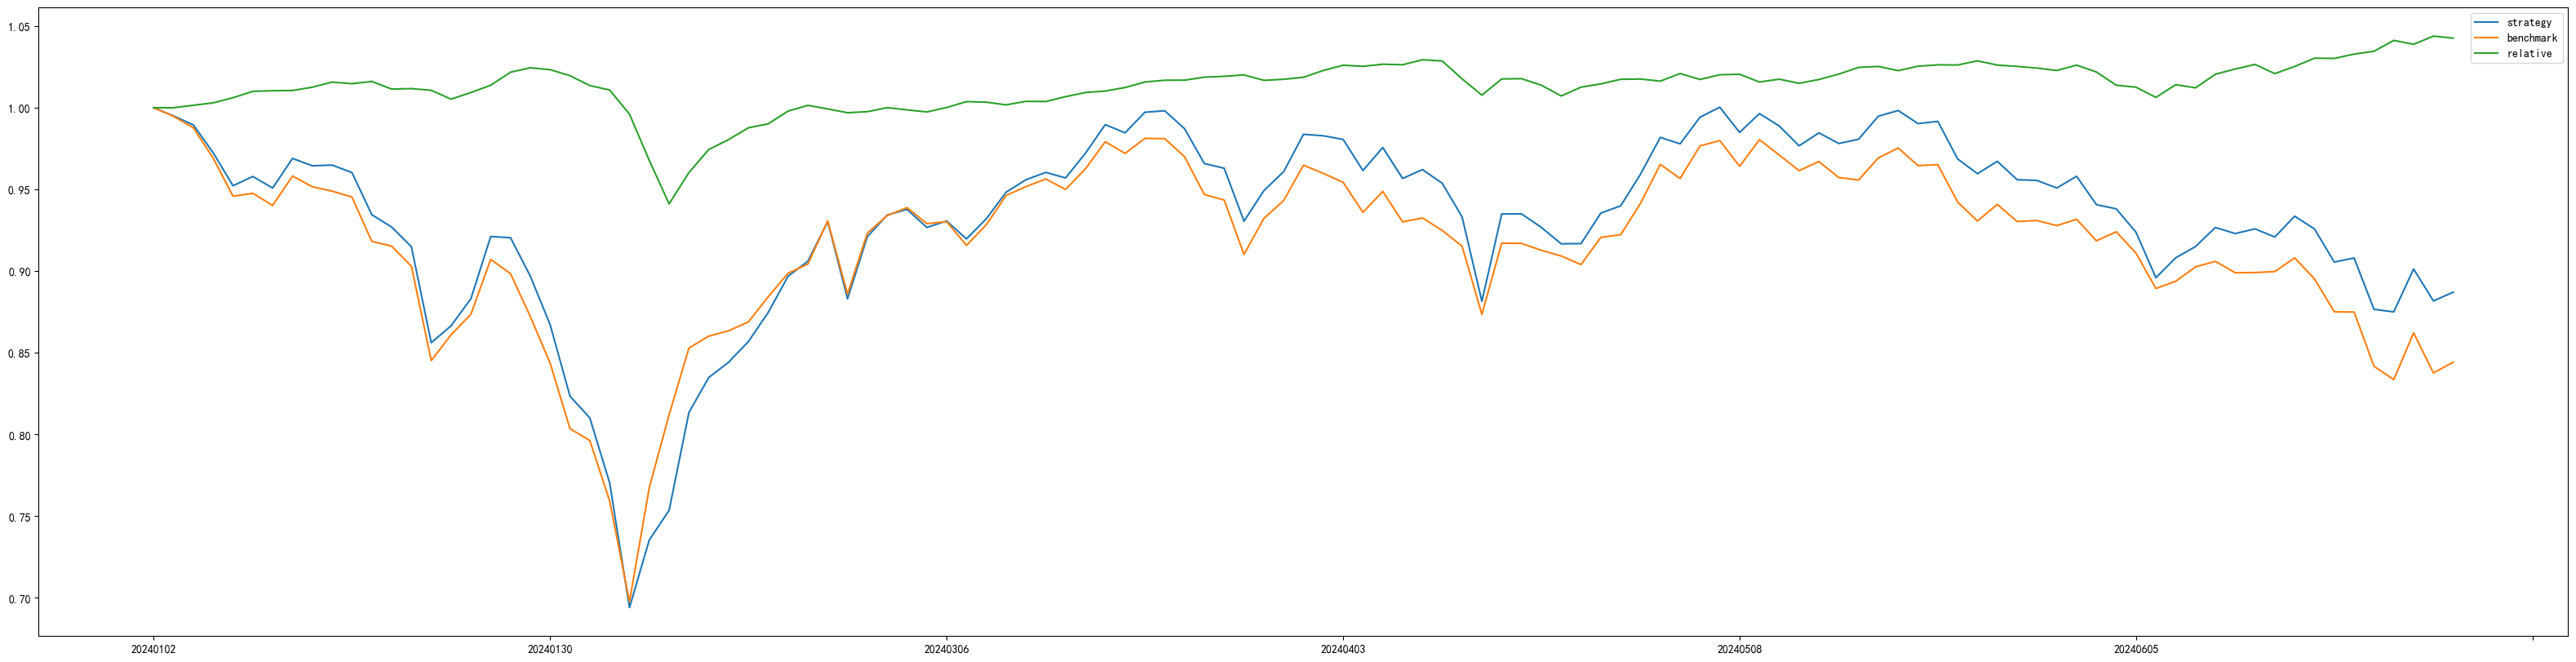

{'tot_account_s':                   tot_account          cash       buy_amt  sell_amt
 2024-01-02 930   1.000000e+08  1.000000e+08  0.000000e+00       0.0
            931   1.000000e+08  9.777205e+02  9.999902e+07       0.0
            932   9.998372e+07  9.777205e+02  0.000000e+00       0.0
            933   9.994056e+07  9.777205e+02  0.000000e+00       0.0
            934   9.990359e+07  9.777205e+02  0.000000e+00       0.0
 ...                       ...           ...           ...       ...
 2024-06-28 957   8.760288e+07  1.104808e+06  0.000000e+00       0.0
            958   8.759145e+07  1.104808e+06  0.000000e+00       0.0
            959   8.756981e+07  1.104808e+06  0.000000e+00       0.0
            1000  8.755887e+07  1.104808e+06  0.000000e+00       0.0
            1500  8.685275e+07  1.104808e+06  0.000000e+00       0.0
 
 [3744 rows x 4 columns],
 'hold_df_dict': {datetime.date(2024, 1, 2):               0              1  score_1d_min
  000030  61400.0  327380.658762     

In [221]:
#5分钟vwap价格成交
params.score_dict = {'1d_min':{'tabnet':r'/home/datamake94/database_00/min_score_period30/min_score_lgbm_new_agg_tabnet4',},}
func_backtest(perm_stock=0.0033, # 持仓期间行业偏离比例
stk_trade_share=0.1, # 个股每分钟参与比例上限
cash_limit_high=0.1,
initial_money = 100000000,  
save_result=True)

0 20240102 99728325.93216074 641.9321607332095 99999358.06783928 100000000.0 nan 438 0.3059590514758611 nan
1 20240103 99270465.21677944 1463155.2167794432 24507465.362923402 9933268.915786209 1.0006536535192516 522 0.35295812407664917 0.0
2 20240104 98738485.60409783 1683305.604097826 19656313.657662556 9885172.66307659 1.0023392333135712 552 0.3680279885459869 0.0
3 20240105 97004720.96408238 665848.9640823732 17784843.124525815 9842427.128934747 1.0033182240910046 548 0.3429652467591788 0.0
4 20240108 95113952.72613488 445805.72613488487 15495853.51020708 9649766.230393223 1.007124646129061 553 0.3355991344893767 0.0
5 20240109 95601298.28961624 721438.2896162368 17452024.653552547 9529412.926545402 1.0104934485839774 545 0.3167437648094804 0.0
6 20240110 94899683.90178102 962020.9017810187 15688462.863015104 9487682.016412098 1.010579777606644 544 0.3022538267720338 0.0
7 20240111 96518879.9167729 547877.9167729022 17973663.5613204 9482955.148408718 1.0096729741600494 574 0.3261606

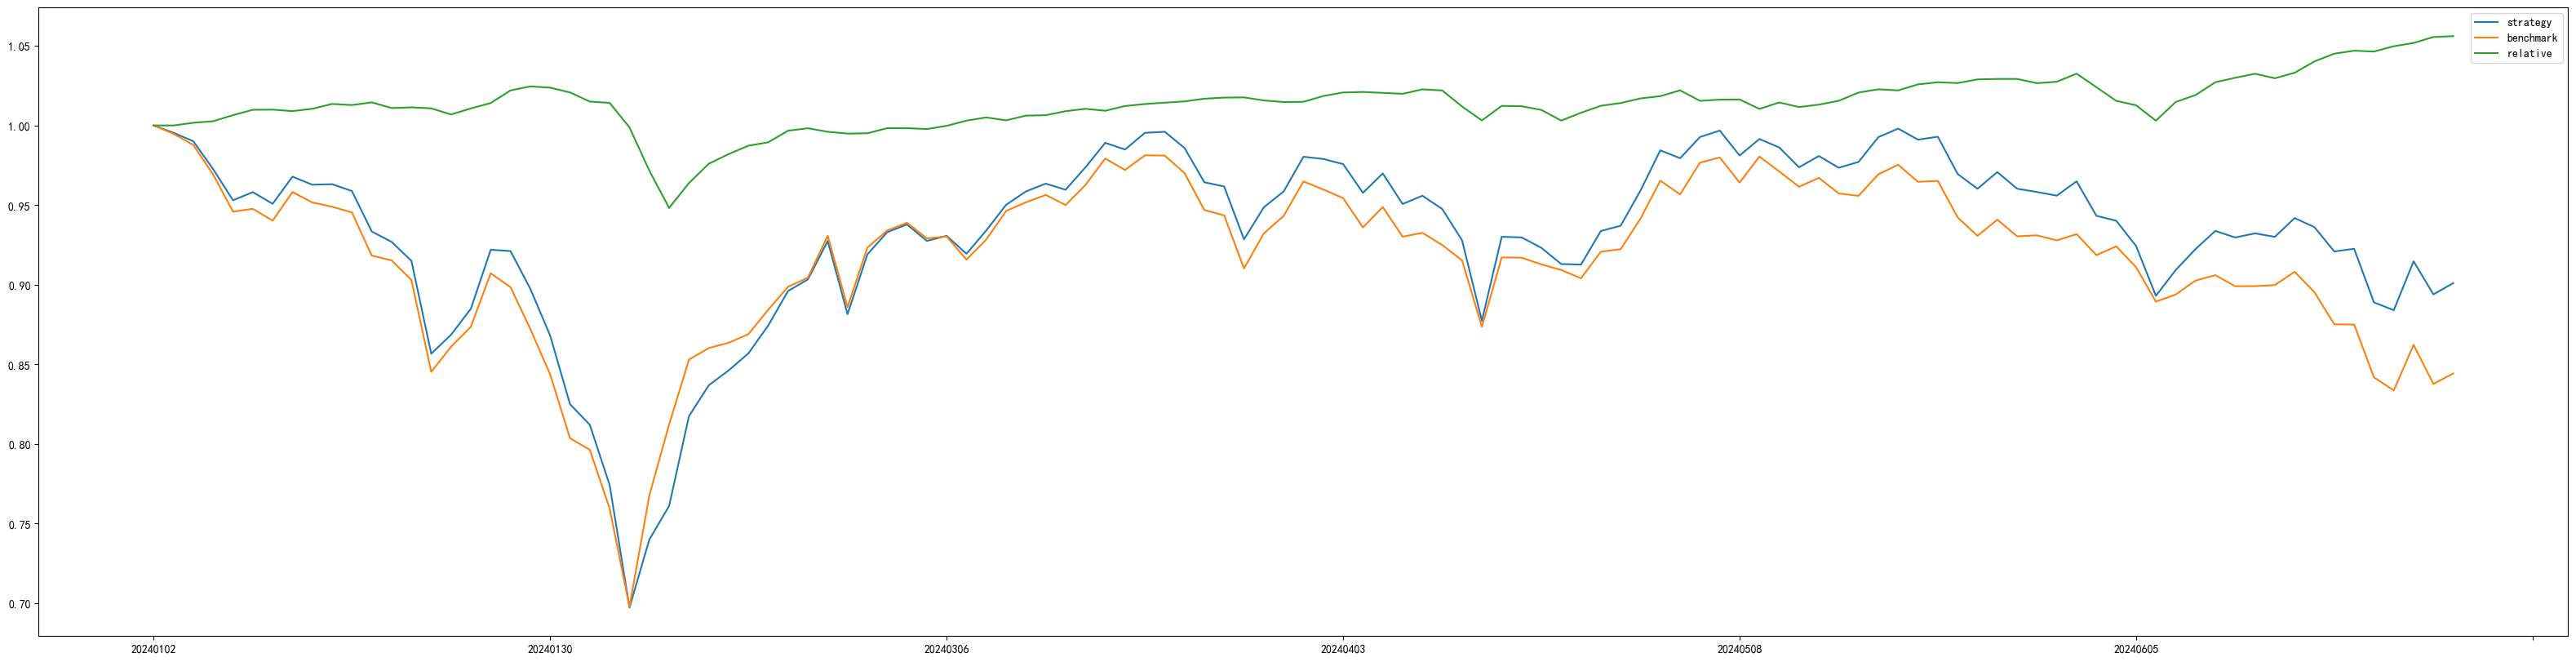

{'tot_account_s':                   tot_account          cash       buy_amt  sell_amt
 2024-01-02 930   1.000000e+08  1.000000e+08  0.000000e+00       0.0
            931   1.000000e+08  6.419322e+02  9.999936e+07       0.0
            932   1.000531e+08  6.419322e+02  0.000000e+00       0.0
            933   9.996957e+07  6.419322e+02  0.000000e+00       0.0
            934   9.992082e+07  6.419322e+02  0.000000e+00       0.0
 ...                       ...           ...           ...       ...
 2024-06-28 957   8.872683e+07  8.719567e+06  0.000000e+00       0.0
            958   8.875832e+07  8.719567e+06  0.000000e+00       0.0
            959   8.871325e+07  8.719567e+06  0.000000e+00       0.0
            1000  8.874443e+07  8.719567e+06  0.000000e+00       0.0
            1500  8.812016e+07  8.719567e+06  0.000000e+00       0.0
 
 [3744 rows x 4 columns],
 'hold_df_dict': {datetime.date(2024, 1, 2):               0              1  score_1d_min
  000030  42800.0  227417.542169     

In [203]:
#
params.score_dict = {'1d_min':{'tabnet':r'/home/datamake94/database_00/min_score_period30/min_score_lgbm_new_agg_tabnet4',},}
func_backtest(perm_stock=0.0033, # 持仓期间行业偏离比例
stk_trade_share=0.1, # 个股每分钟参与比例上限
cash_limit_high=0.1,
initial_money = 100000000,  
save_result=True)

0 20240102 99605947.43967864 116.43967863898456 99999883.56032129 100000000.0 nan 459 0.26266421591747324 nan
1 20240103 99123844.56015071 490927.56015070603 20024395.807829145 9924459.850166788 1.0004046321081352 511 0.30338152151410747 0.0
2 20240104 98564148.44326478 1163781.443264789 15305950.144425238 9871391.29380625 1.0018026703077672 543 0.3119947010823228 0.0
3 20240105 96911748.7739194 577024.7739194031 16161791.24063467 9824040.726816371 1.0035761057002694 577 0.31753575915856797 0.0
4 20240108 94915926.39949887 771283.3994988695 12842624.536409501 8363271.287489582 1.006279809998124 581 0.30656894468819085 0.0
5 20240109 95361845.72995274 771371.7299527343 15773719.047568517 9506045.582011648 1.0092228505622154 571 0.3064593818221037 0.0
6 20240110 94701279.50452742 1067707.5045274196 9738903.065507382 5063747.589619852 1.00972119792032 582 0.3041075396121527 0.0
7 20240111 96272048.1031781 550407.1031780964 15318831.636172298 9460845.965585113 1.0083387704490259 597 0.3246

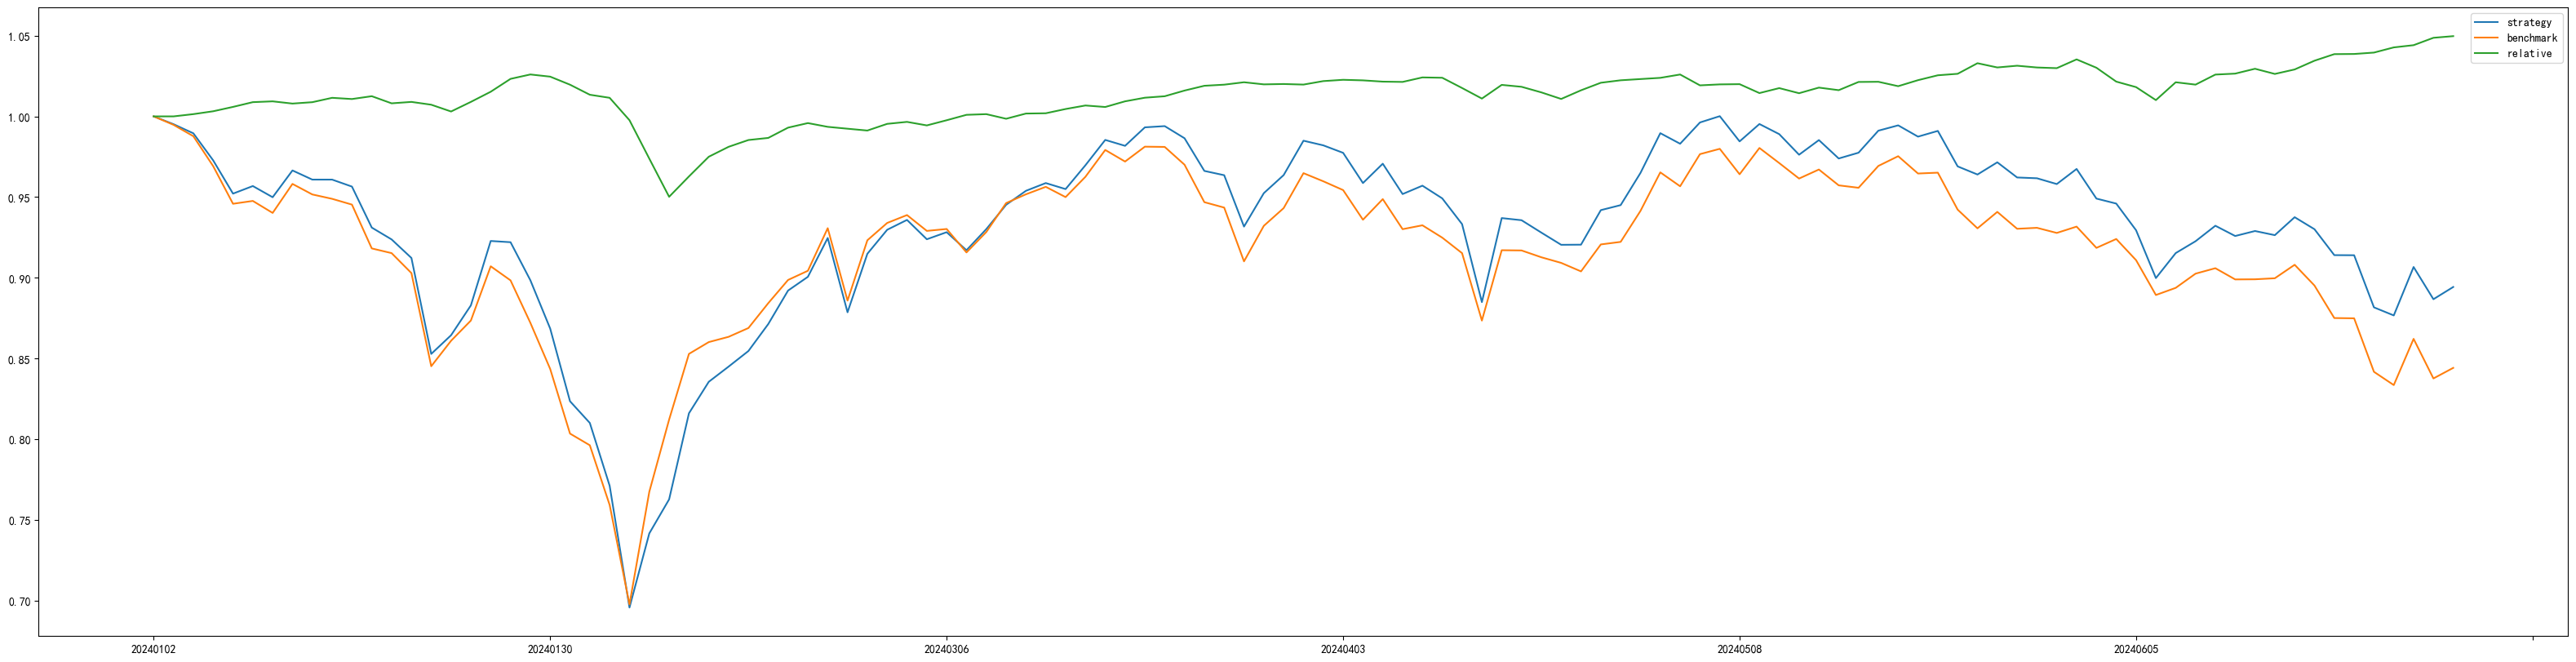

{'tot_account_s':                   tot_account          cash       buy_amt  sell_amt
 2024-01-02 930   1.000000e+08  1.000000e+08  0.000000e+00       0.0
            931   1.000000e+08  1.164397e+02  9.999988e+07       0.0
            932   1.000323e+08  1.164397e+02  0.000000e+00       0.0
            933   9.994503e+07  1.164397e+02  0.000000e+00       0.0
            934   9.988239e+07  1.164397e+02  0.000000e+00       0.0
 ...                       ...           ...           ...       ...
 2024-06-28 957   8.801555e+07  6.983003e+06  0.000000e+00       0.0
            958   8.806184e+07  6.983003e+06  0.000000e+00       0.0
            959   8.802088e+07  6.983003e+06  0.000000e+00       0.0
            1000  8.804593e+07  6.983003e+06  0.000000e+00       0.0
            1500  8.747256e+07  6.983003e+06  0.000000e+00       0.0
 
 [3744 rows x 4 columns],
 'hold_df_dict': {datetime.date(2024, 1, 2):               0              1  score_1d_min
  000030  42800.0  227417.542169     

In [205]:
#
params.score_dict = {'1d_min':{'tabnet':r'/home/datamake94/database_00/min_score_period30/min_score_lgbm_new_agg_tabnetk4',},}
func_backtest(perm_stock=0.0033, # 持仓期间行业偏离比例
stk_trade_share=0.1, # 个股每分钟参与比例上限
cash_limit_high=0.1,
initial_money = 100000000,  
save_result=True)

0 20240102 99667898.25720754 640.2572075472951 99999359.7427925 100000000.0 nan 445 0.37910260109988186 nan
1 20240103 99321995.60875846 1548458.6087584575 24274328.983514085 9927732.358108012 1.0017741811976668 519 0.40882774235489483 0.0
2 20240104 98877231.47504622 2337388.475046211 18896845.973793283 9890541.189197062 1.004340649703416 552 0.4116752702992591 0.0
3 20240105 97167236.0311005 445074.031100494 20015500.706287824 9855735.482095523 1.0055846707239833 564 0.35821380875139774 0.0
4 20240108 95257993.68618022 818156.6861802256 16967635.402841736 9662654.205894139 1.00923356596634 534 0.385381077328697 0.0
5 20240109 95716242.15923369 1074777.1592336942 17626516.737508614 9540918.670984562 1.0122891650102548 513 0.3506039780037864 0.0
6 20240110 95085466.2896917 923411.2896917065 16436323.83012101 9500343.707830252 1.0131243960528784 518 0.3310907697371694 0.0
7 20240111 96753270.44099629 926441.4409962818 17339812.203924365 9507084.809829894 1.0126954604078735 538 0.3582213

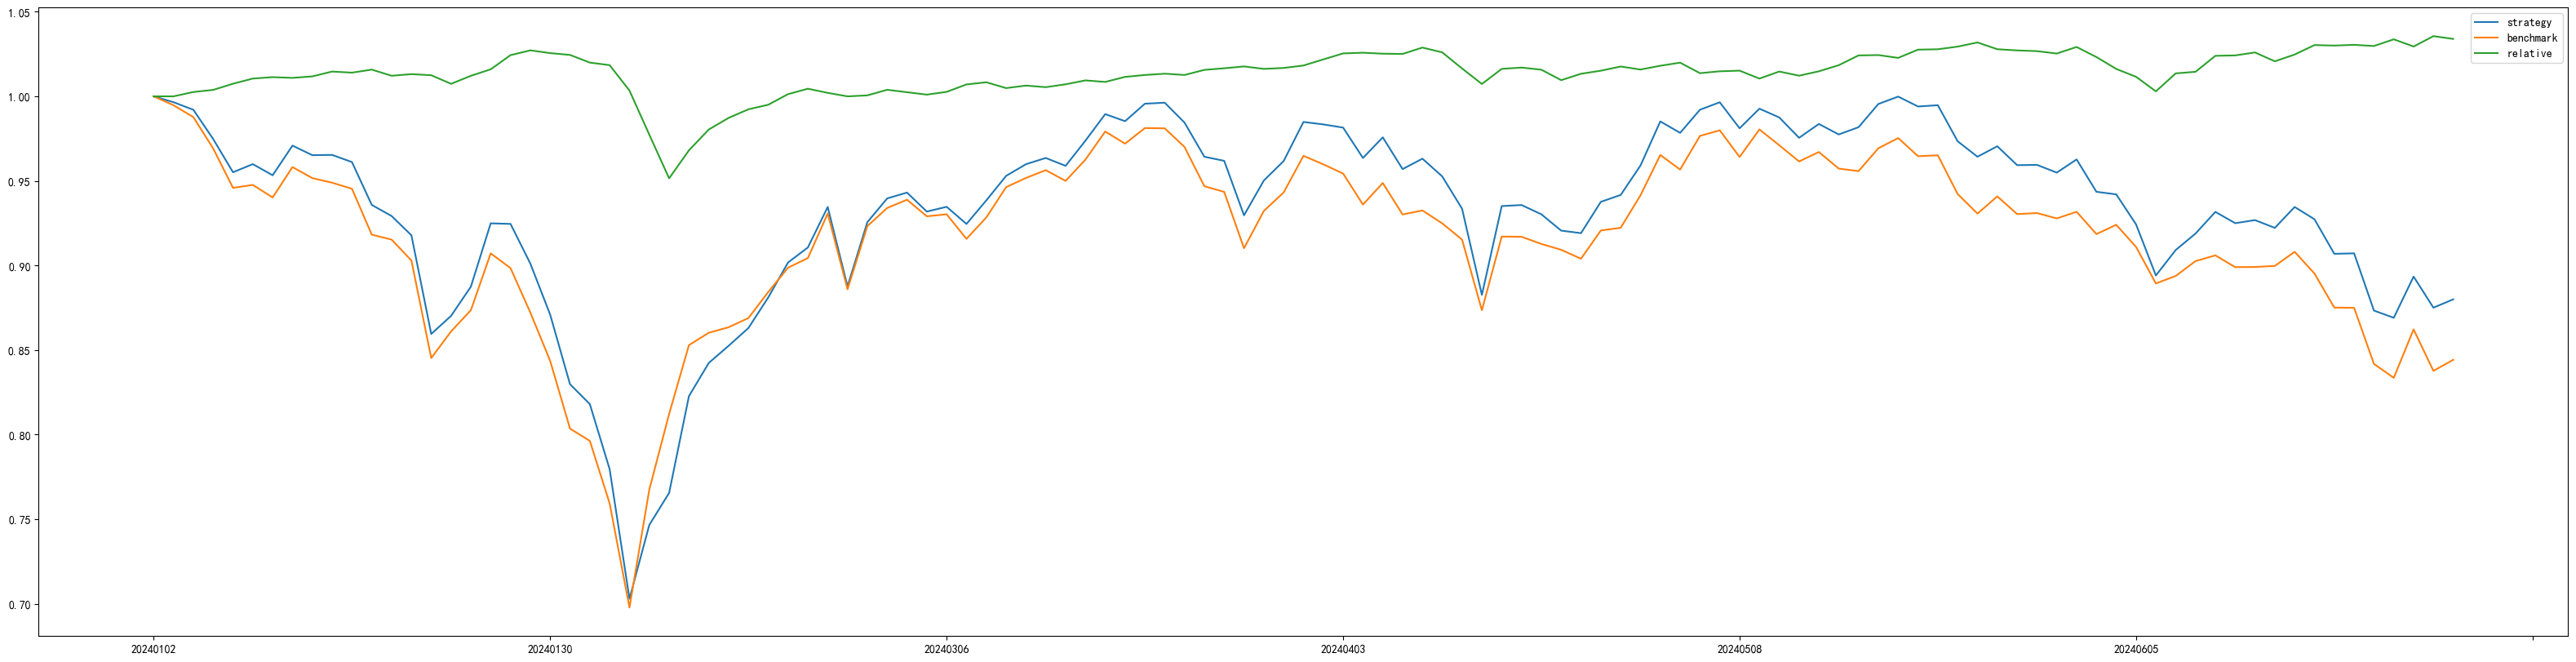

{'tot_account_s':                   tot_account          cash       buy_amt  sell_amt
 2024-01-02 930   1.000000e+08  1.000000e+08  0.000000e+00       0.0
            931   1.000000e+08  6.402572e+02  9.999936e+07       0.0
            932   1.000386e+08  6.402572e+02  0.000000e+00       0.0
            933   9.996118e+07  6.402572e+02  0.000000e+00       0.0
            934   9.991238e+07  6.402572e+02  0.000000e+00       0.0
 ...                       ...           ...           ...       ...
 2024-06-28 957   8.697732e+07  8.570021e+06  0.000000e+00       0.0
            958   8.702397e+07  8.570021e+06  0.000000e+00       0.0
            959   8.699333e+07  8.570021e+06  0.000000e+00       0.0
            1000  8.703396e+07  8.570021e+06  0.000000e+00       0.0
            1500  8.626939e+07  8.570021e+06  0.000000e+00       0.0
 
 [3744 rows x 4 columns],
 'hold_df_dict': {datetime.date(2024, 1, 2):               0              1  score_1d_min
  000012  17400.0   96716.168246     

In [195]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，中证1000
func_backtest(perm_stock=0.0033, # 持仓期间行业偏离比例
stk_trade_share=0.1, # 个股每分钟参与比例上限
cash_limit_high=0.1,
initial_money = 100000000,  
save_result=True)

0 20240102 99634157.57674304 599.5767430361884 99999400.423257 100000000.0 nan 458 0.38210305907622927 nan
1 20240103 99308028.12151167 3360155.1215116684 39483774.33315064 9941621.23109881 1.0019714638856656 585 0.48659859142331424 0.0
2 20240104 99024295.18556288 3726411.1855628835 35562785.83972506 9892908.786951726 1.0061588350955266 564 0.5208934766009177 0.0
3 20240105 97364894.36863531 2381120.368635305 32458974.926263444 9869282.257406684 1.007939471554486 588 0.44361209317132 0.0
4 20240108 95439774.60876393 1861389.6087639313 29972679.140047103 9686502.472258344 1.0114651846212481 503 0.45819938393589293 0.0
5 20240109 95875433.845848 9563949.84584799 11416730.401089512 9563949.84584799 1.0142749353060774 516 0.3840070666498264 0.0
6 20240110 95477583.7570534 2722891.7570534055 30586667.882172935 9563949.84584799 1.0175505710934742 510 0.39125206887915975 0.0
7 20240111 97004896.33952622 3014058.3395262267 27170756.000666603 9540342.070433555 1.0155781388042433 545 0.43512194

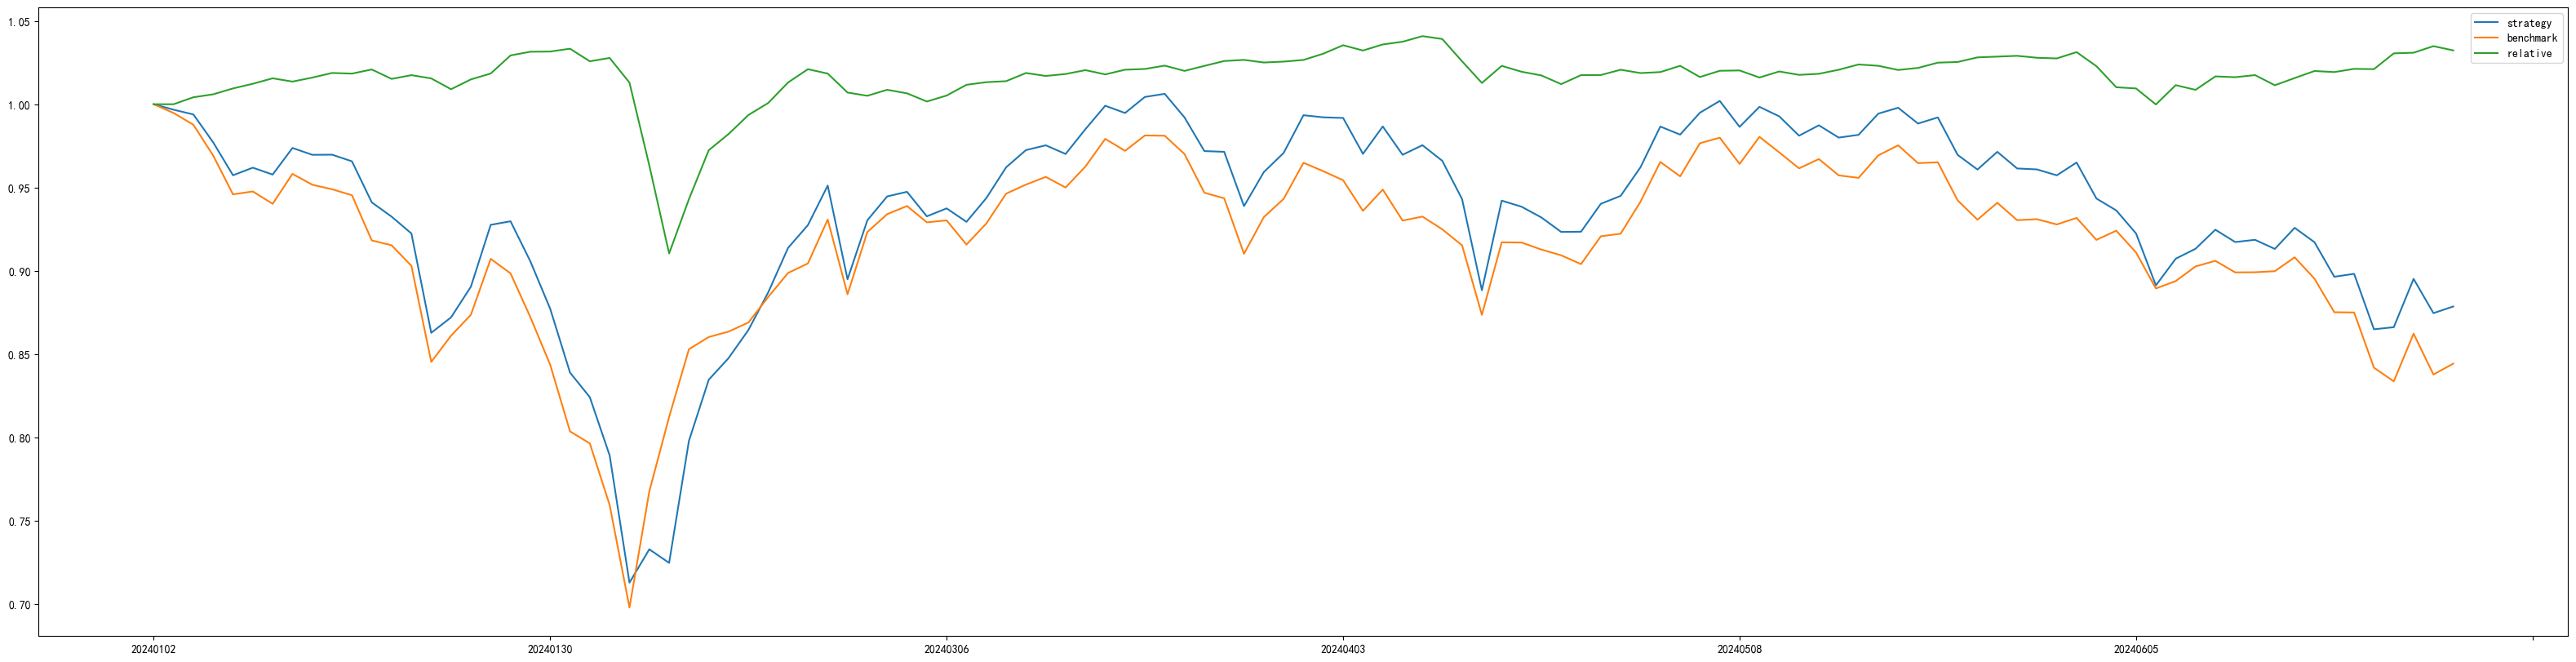

{'tot_account_s':                   tot_account          cash       buy_amt  sell_amt
 2024-01-02 930   1.000000e+08  1.000000e+08  0.000000e+00       0.0
            931   1.000000e+08  5.995767e+02  9.999940e+07       0.0
            932   1.000304e+08  5.995767e+02  0.000000e+00       0.0
            933   9.993903e+07  5.995767e+02  0.000000e+00       0.0
            934   9.988437e+07  5.995767e+02  0.000000e+00       0.0
 ...                       ...           ...           ...       ...
 2024-06-28 957   8.682659e+07  8.535471e+06  0.000000e+00       0.0
            958   8.688116e+07  8.535471e+06  0.000000e+00       0.0
            959   8.683635e+07  8.535471e+06  0.000000e+00       0.0
            1000  8.689429e+07  8.535471e+06  0.000000e+00       0.0
            1500  8.595627e+07  8.535471e+06  0.000000e+00       0.0
 
 [3744 rows x 4 columns],
 'hold_df_dict': {datetime.date(2024, 1, 2):               0              1  score_1d_min
  000012  17400.0   96716.168246     

In [191]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，中证1000
func_backtest(perm_stock=0.0033, # 持仓期间行业偏离比例
stk_trade_share=0.1, # 个股每分钟参与比例上限
cash_limit_high=0.1,
initial_money = 100000000,  
save_result=True)

In [175]:
params.zs_nv.loc[date_list]

2024-01-30    1.064238
2024-01-31    1.021617
2024-02-01    1.014232
2024-02-02    0.976704
2024-02-05    0.916582
                ...   
2024-06-24    1.043553
2024-06-25    1.034978
2024-06-26    1.064606
2024-06-27    1.038495
2024-06-28    1.045306
Length: 97, dtype: float64

In [105]:
test = info_s['hold_df_dict'][date_list[12]]
open_price = params.oh_data['CLOSE_PRICE'].fillna(method='ffill').loc[date_list[11].strftime('%Y%m%d')]#.reindex(index=test.index)
open_price.index = ['%06d'%x for x in open_price.index]
open_price = open_price.reindex(index=test.index)
close_price = params.oh_data['CLOSE_PRICE'].fillna(method='ffill').loc[date_list[12].strftime('%Y%m%d')]#.reindex(index=test.index)
close_price.index = ['%06d'%x for x in close_price.index]
close_price = close_price.reindex(index=test.index)
open_value = test[0] @ open_price
close_value = test[0] @ close_price
(close_value - open_value) / open_value

-0.00917741784640183

In [113]:
info_s['tot_account_s'].loc[date_list[12]]

,tot_account,cash,buy_amt,sell_amt
920,9.498668e+07,1.576631e+06,0.000000e+00,0.000000e+00
924,9.498668e+07,1.576631e+06,0.000000e+00,0.000000e+00
930,9.498668e+07,1.576631e+06,0.000000e+00,0.000000e+00
931,9.267852e+07,9.488099e+06,1.576116e+06,9.497081e+06
932,9.267852e+07,9.488099e+06,0.000000e+00,0.000000e+00
...,...,...,...,...
1455,9.222728e+07,1.862563e+06,0.000000e+00,0.000000e+00
1456,9.222728e+07,1.862563e+06,0.000000e+00,0.000000e+00
1457,9.222728e+07,1.862563e+06,0.000000e+00,0.000000e+00
1458,9.222728e+07,1.862563e+06,0.000000e+00,0.000000e+00


In [104]:
params.zs_nv.loc[date_list[11]:].pct_change()

2024-01-17         NaN
2024-01-18   -0.002913
2024-01-19   -0.012364
2024-01-22   -0.057689
2024-01-23    0.015757
                ...   
2024-10-14    0.036738
2024-10-15   -0.019335
2024-10-16    0.003101
2024-10-17   -0.003374
2024-10-18    0.044286
Length: 179, dtype: float64

In [204]:
perm_stock=0.0033
stk_trade_share=0.1 # 个股每分钟参与比例上限
cash_limit_high=0.1
initial_money = 100000000
save_result=True

s = account(initial_money) # 策略初始化
s.cal_tot()
s.time = date_list[0].strftime('%Y%m%d')
# sell_rank_ratio = min(1-buy_rank_ratio,sell_rank_ratio)

para = {'im':initial_money/100000000}

hold_df_dict = {} # 保存每日持仓记录
trade_df_dict = {} # 保存每日交易记录
decision_dict = {} # 保存每日交易决策记录
tot_account_dict = {} # 保存每日每分钟现金、总持仓金额、换手金额等
rank_df = {} # 保存每日每分钟平均持仓排名
max_dd = 0 # 最大回撤

In [205]:
def update_daily_static_data(date, date_str, pre_date, pre_date_str):
    td_black = pd.read_csv(r'/home/datamake94/data_nb1/black_list/%s_black_list.csv'%date_str,index_col=0)
    td_black = td_black[td_black['black']==True].index.tolist()

    os.chdir(params.support_path)
    td_support = pd.read_csv(date_str+'_trade_support.csv')  # 当天盘前可获取到的信息
    td_support['index'] = td_support['index'].apply(lambda x:'%06d'%x)
    td_support = td_support.rename({'index':'code'},axis=1).set_index('code',drop=True)

    close_price,min_amt = get_min_data(date,date_str)
    close_price = close_price.T
    min_amt = min_amt.T
    close_price.columns = close_price.columns.astype(int)

    # 提取个股信息
    td_upper = params.upper_price.loc[date].dropna()
    td_lower = params.lower_price.loc[date].dropna()
    td_preclose = params.pre_close.loc[date].dropna()
    td_citic = td_support['citic1_code']
    td_cmvg = td_support['cmv_group']
    td_adj = params.adj.loc[date].replace(1,np.nan).dropna().to_dict()
    code_list = pd.concat([td_citic, td_cmvg, td_upper,td_lower,close_price[930]],axis=1).dropna(how='any').index.tolist() # 今日可考虑的正常交易的股票列表

    sub_code = (td_support['ipo_dates']>20) & (td_support['st']==0) # 筛选中证1000成分股、上市20交易日以上、非ST股票
    sub_code_list = sub_code[sub_code].index.tolist()
    code_list = [x for x in code_list if x[:2] in ['00','30','60','68']]
    code_list = [x for x in code_list if x in sub_code_list] # 再根据信息情况取交集
    code_list = [x for x in code_list if x not in td_black]
    return td_black, td_support, close_price, min_amt, td_upper, td_lower, td_preclose, td_citic, td_cmvg, td_adj, code_list

def get_index_data(td_support, code_list):
    # 提取指数信息
    zs_citic_dict, zs_cmvg_dict, zs_member_dict = {}, {}, {}
    for idx in ['hs300','zz500','zz1000']:
        zs_citic = td_support[['citic1_code',idx+'_citic1']].drop_duplicates('citic1_code').set_index('citic1_code')[idx+'_citic1'].sort_index()
        zs_cmvg = td_support[['cmv_group',idx+'_cmvg']].drop_duplicates('cmv_group').set_index('cmv_group')[idx+'_cmvg'].sort_index()
        zs_member = td_support[idx+'_member']
        zs_citic_dict[idx] = zs_citic
        zs_cmvg_dict[idx] = zs_cmvg
        zs_member_dict[idx] = zs_member
    zs_weight = pd.Series(params.zs_w_dict)
    zs_citic = sum([zs_citic_dict[idx].fillna(0)*zs_weight[{'hs300':'沪深300','zz500':'中证500','zz1000':'中证1000'}[idx]] for idx in ['hs300','zz500','zz1000']]).sort_index()
    zs_member = sum([zs_member_dict[idx].fillna(0)*zs_weight[{'hs300':'沪深300','zz500':'中证500','zz1000':'中证1000'}[idx]] for idx in ['hs300','zz500','zz1000']])
    zs_member = zs_member.reindex(index=code_list).fillna(0)
    return zs_citic, zs_member

In [206]:
num = 0

date = date_list[num]
date_str = date.strftime('%Y%m%d')
pre_date = date_list_all[date_list_all.index(date)-1]
pre_date_str = pre_date.strftime('%Y%m%d')
#获取基本信息
td_black, td_support, close_price, min_amt, td_upper, td_lower, td_preclose, td_citic, td_cmvg, td_adj, code_list = update_daily_static_data(date, date_str, pre_date, pre_date_str)
zs_citic, zs_member = get_index_data(td_support, code_list)

min_sec_list = sorted(close_price.columns.tolist())
trade_min_sec = [x for x in min_sec_list if (x>929.0) and (x<1500.0)] #  and (x != round(x))
# code_list,td_upper,td_lower,td_pre_close,perm_ratio,stk_citic,zs_citic,zs_member,date_str,pre_date_str
account0 = s.refresh_open(code_list,td_upper.to_dict(),td_lower.to_dict(),td_preclose.to_dict(),0.0033,td_citic.reindex(code_list),zs_citic,zs_member,date_str,pre_date_str)
alpha_dict = get_alpha_dict(date_str,pre_date_str,code_list)

account_s = {} # pd.Series([account0]*len(minute_list),index=minute_list)
cash_s = {} # pd.Series([0]*len(minute_list),index=minute_list)
buy_s = {} # pd.Series([0]*len(minute_list),index=minute_list)
sell_s = {}
rank_s = {}

for m in min_sec_list: #minute_list[1:]:#  # 从0930开始，刷新分钟行情，获取当前分钟alpha信号，设置alpha阈值，做出交易决策
    s.time = date_str+' '+str(m)
    if m <= 930 or m >= 1000:
        min_price_s = close_price[m]
        s.fresh_price(min_price_s.to_dict())
        buy_amt,sell_amt = 0,0
    elif m in trade_min_sec and m%5==1:
        min_amt_s = min_amt[m] * stk_trade_share
        min_amt_s = min_amt_s.reindex(index=code_list).fillna(0)
        # min_amt_s[min_amt_s>10000]=10000
        min_price_s = close_price[m]
            
        # elif m<=1000:
        alpha_s = alpha_dict['1d_min'].loc[m].values
        cash_high = s.tot_account * cash_limit_high
        max_buy = s.cash
        max_sell = cash_high - s.cash
        s.fresh_minute(min_amt_s.to_dict(), min_price_s.to_dict())
        buy_amt, sell_amt = s.decide_clean(max_buy, max_sell, min_price_s, alpha_s, min_amt_s, min_turnlimit=1)
        print(buy_amt, sell_amt)
    else:
        s.fresh_price(min_price_s.to_dict())
        buy_amt,sell_amt = 0,0

    account_s[m] = s.cal_tot()
    cash_s[m] = s.cash
    buy_s[m] = buy_amt
    sell_s[m] = sell_amt

99999927.18478769 0
0 0
0 0
0 0
0 0
0 0


In [207]:
s.tot_account

99650791.07248046

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，中证1000
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，中证1000
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，中证1000
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，中证1000
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，中证1000
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，343
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，三指数平分
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.05, # 平仓阈值
sell_rank_ratio_noon=0.025,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，涛哥约束方式
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，final，修正打分，最终
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，final，修正打分
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，final
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，final
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，带简易版T0
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，带简易版T0
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，norm+tabnet
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，norm+tabnet
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，norm+tabnet
params.score_dict['1d_min']['tabnet'] = r'/home/datamake94/database_00/min_score_period30/min_score_period1d_allstock_adj_Tabnet_new6_select3'
params.score_dict['1d_min']['norm'] = r'/home/datamake94/database_00/min_score_period30/min_score_period1d_allstock_adj_transformer_final_select3_doublenorm_qcut'
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，norm+tabnet
params.score_dict['1d_min']['tabnet'] = r'/home/datamake94/database_00/min_score_period30/min_score_period1d_allstock_adj_Tabnet_new6_select3'
params.score_dict['1d_min']['norm'] = r'/home/datamake94/database_00/min_score_period30/min_score_period1d_allstock_adj_transformer_final_select3_doublenorm_qcut'
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，norm+tabnet_exret
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，norm+tabnet_exret
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，norm+tabnet_exret
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，norm+tabnet
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股，norm+tabnet+factorvae
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=False)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，80%成分股
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，60%成分股
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，60%成分股
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodeqcut0
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值  
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+node
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [ ]:
#最终_tabnet，调整印花税，新市值约束，norm_qcut
info_s = func_backtest(citic_share_limit=0.01, # 持仓期间行业偏离比例
cmvg_share_limit=0.15, # 持仓期间市值偏离比例
citic_share_limit_low=0.01,
cmvg_share_limit_low=0.2,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=1, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 2000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)